In [1]:



import os


os.chdir('/Users/alex/ZSCIR/')

print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/alex/ZSCIR


In [2]:
import json
from typing import List

import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
from rich import print
import matplotlib.pyplot as plt
from clip import tokenize
from transformers import CLIPVisionModelWithProjection, CLIPTextModelWithProjection, CLIPImageProcessor

from src.fashioniq_experiment.utils import element_wise_sum_original, get_combing_function_with_alpha, \
    convert_to_pivot_fiq, prepare_and_plot_recall_pivot, prepare_ground_truths, plot_retrieval_results_of_i, \
    found_better_than_original
from src.fashioniq_experiment.validate_notebook import fiq_val_retrieval_text_image_grid_search_clip, \
    compute_results_fiq_val_clip
from src.utils import device

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 1: Set up the experiment</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Set up the cache for the experiment</div>

In [3]:
cache = {}

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Same concept as script version here</div>

In [4]:
CLIP_NAME = 'laion/CLIP-ViT-B-32-laion2B-s34B-b79K'

In [5]:
clip_text_encoder = CLIPTextModelWithProjection.from_pretrained(CLIP_NAME, torch_dtype=torch.float32, projection_dim=512)
clip_text_encoder = clip_text_encoder.float().to(device)

print("clip text encoder loaded.")
clip_text_encoder.eval()

clip text encoder loaded.

CLIPTextModelWithProjection(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,

In [6]:
print('CLIP preprocess pipeline is used')
preprocess = CLIPImageProcessor(
    crop_size={'height': 224, 'width': 224},
    do_center_crop=True,
    do_convert_rgb=True,
    do_normalize=True,
    do_rescale=True,
    do_resize=True,
    image_mean=[0.48145466, 0.4578275, 0.40821073],
    image_std=[0.26862954, 0.26130258, 0.27577711],
    resample=3,
    size={'shortest_edge': 224},
)

CLIP preprocess pipeline is used

In [7]:
clip_tokenizer = tokenize

In [8]:
combining_function_original = element_wise_sum_original

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 2: Load the MLLM generated text captions</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Load the addition text captions</div>

In [9]:
with open('./fashionIQ_dataset/labeled_images_cir_cleaned.json', 'r') as f:
    text_captions = json.load(f)
    
total_recall_list: List[List[pd.DataFrame]] = []

print(f'Total number of text captions: {len(text_captions)}')

Total number of text captions: 15412

In [10]:
clip_img_encoder = CLIPVisionModelWithProjection.from_pretrained("laion/CLIP-ViT-B-32-laion2B-s34B-b79K")

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 3: Perform retrieval on the FashionIQ dataset</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the shirt category</div>

In [14]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
shirt_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    shirt_recall = fiq_val_retrieval_text_image_grid_search_clip(
        'shirt',
        get_combing_function_with_alpha(alpha),
        clip_text_encoder,
        clip_img_encoder,
        clip_tokenizer,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    shirt_recall_list.append(shirt_recall)

shirt_recall_at10, shirt_recall_at50 = convert_to_pivot_fiq(shirt_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

Exception: [Errno 2] No such file or directory: '/Users/alex/ZSCIR/fashionIQ_dataset/images/B000KENMD8.png'
Exception: [Errno 2] No such file or directory: '/Users/alex/ZSCIR/fashionIQ_dataset/images/B005AD7WZI.png'
Exception: [Errno 2] No such file or directory: '/Users/alex/ZSCIR/fashionIQ_dataset/images/B006VY4S1Q.png'
Exception: [Errno 2] No such file or directory: '/Users/alex/ZSCIR/fashionIQ_dataset/images/B0013EO152.png'
Exception: [Errno 2] No such file or directory: '/Users/alex/ZSCIR/fashionIQ_dataset/images/B001L95W7K.png'
Exception: [Errno 2] No such file or directory: '/Users/alex/ZSCIR/fashionIQ_dataset/images/B00DI9YY8O.png'
Exception: [Errno 2] No such file or directory: '/Users/alex/ZSCIR/fashionIQ_dataset/images/B001CMIN4K.png'
Exception: [Errno 2] No such file or directory: '/Users/alex/ZSCIR/fashionIQ_dataset/images/B00C40R3FY.png'
Exception: [Errno 2] No such file or directory: '/Users/alex/ZSCIR/fashionIQ_dataset/images/B008LIH5VU.png'Exception: [Errno 2] No such 

TypeError: cannot unpack non-iterable NoneType object

In [11]:
display(shirt_recall_at10, shirt_recall_at50)

alpha      0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                     
0.00   9.617272   9.862611  10.304220  10.549559  11.040235  11.481845   
0.05   9.568204  10.107949  10.304220  10.696761  11.040235  11.530913   
0.10   9.470069   9.862611  10.304220  10.598626  10.991168  11.629048   
0.15   9.371933   9.617272  10.058881  10.696761  11.187439  11.579981   
0.20   9.273798   9.519137  10.009813  10.549559  11.285574  12.021590   
0.25   9.273798   9.617272  10.107949  10.696761  11.285574  11.776251   
0.30   9.077527   9.617272  10.107949  10.549559  11.236507  11.530913   
0.35   8.881256   9.322865  10.009813  10.206085  10.843965  11.678116   
0.40   8.930324   9.175663   9.666339  10.206085  10.647694  11.579981   
0.45   8.586850   8.930324   9.470069   9.911678  10.647694  11.383709   
0.50   8.292443   8.586850   8.979391   9.470069  10.107949  10.893033   
0.55   8.047105   8.096173   8.537782   9.077527   9.617272  10.255152   
0.60   7.360157   7.703631   8.047105   8.783121   9.273798   9.813543   
0.65   7.114819   7.360157   7.654563   8.292443   8.832189   9.224730   
0.70   6.967615   7.163886   7.409225   7.850834   8.390579   8.635917   
0.75   6.673209   6.771345   6.869480   7.311089   7.654563   8.341511   
0.80   6.035329   6.427871   6.673209   6.869480   7.360157   7.998037   
0.85   5.642787   5.937193   6.476938   6.526006   6.967615   7.605495   
0.90   5.691855   5.839058   6.133464   6.280667   6.526006   7.114819   
0.95   5.446516   5.642787   5.740922   6.084396   6.329735   6.526006   
1.00   5.201178   5.642787   5.691855   5.839058   6.182532   6.133464   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   12.315996  12.904808  13.444553  14.769381  ...  18.056919  20.559372   
0.05   12.217861  13.199215  14.180569  15.456329  ...  19.038273  21.442591   
0.10   12.512267  13.493621  14.622179  15.848872  ...  20.166831  22.620216   
0.15   12.610403  13.591756  14.769381  16.339548  ...  20.412169  22.669284   
0.20   12.659471  13.493621  14.818449  16.683023  ...  20.461236  22.473013   
0.25   12.512267  13.640824  15.112856  16.830225  ...  20.412169  22.374877   
0.30   12.757605  13.984299  15.161924  16.879293  ...  20.117763  21.786065   
0.35   12.561335  13.542689  14.769381  16.584887  ...  20.068695  21.344456   
0.40   12.512267  13.101080  14.622179  16.143277  ...  19.185476  20.068695   
0.45   11.972522  12.904808  13.837095  15.358195  ...  18.547596  19.332679   
0.50   11.579981  12.463199  13.199215  14.867517  ...  17.271835  18.694799   
0.55   10.991168  11.678116  12.904808  13.984299  ...  16.339548  17.566241   
0.60   10.451423  11.334642  12.315996  13.493621  ...  15.358195  16.192345   
0.65   10.058881  11.040235  11.776251  12.659471  ...  14.573111  15.358195   
0.70    9.519137  10.451423  11.187439  12.266929  ...  13.689892  13.886163   
0.75    8.881256   9.862611  11.236507  12.021590  ...  12.708537  12.855741   
0.80    8.537782   9.175663  10.451423  11.236507  ...  11.825319  11.923455   
0.85    8.194308   8.930324  10.255152  10.647694  ...  10.696761  10.794897   
0.90    7.801767   8.537782   9.568204   9.960746  ...  10.255152  10.255152   
0.95    7.065751   7.850834   8.832189   8.979391  ...   9.077527   9.666339   
1.00    6.575073   7.458293   7.850834   8.145241  ...   8.341511   8.979391   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   22.473013  25.220805  27.379784  28.900883  28.851816  26.054955   
0.05   23.748773  26.496565  28.361139  29.489696  28.753680  26.054955   
0.10   24.533857  27.036309  28.753680  29.195291  28.508341  25.760549   
0.15   25.073603  26.545632  28.410205  28.459275  27.968597  25.662413   
0.20  

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   19.185476  19.823356  20.510304  21.246320  22.031404  22.963689   
0.05   19.578017  20.215897  20.755643  21.344456  22.423945  23.552503   
0.10   19.430815  20.166831  20.461236  21.197252  22.325809  23.650637   
0.15   19.087340  19.921492  20.559372  21.197252  22.522080  23.797841   
0.20   19.038273  19.676153  20.608440  21.295388  22.473013  23.895976   
0.25   18.842001  19.381747  20.117763  21.393523  22.571148  23.895976   
0.30   18.694799  19.234544  20.264965  21.050049  22.620216  23.846909   
0.35   18.253189  19.283612  19.921492  20.853779  22.178607  23.797841   
0.40   18.105987  18.940137  19.627085  20.461236  21.835132  23.258096   
0.45   17.517173  18.204121  18.989205  20.166831  21.442591  22.865555   
0.50   17.026496  17.664377  18.204121  19.283612  20.510304  21.933268   
0.55   16.732091  17.173700  17.762512  18.842001  19.970560  21.344456   
0.60   16.094211  16.781157  17.468105  18.204121  19.430815  20.706575   
0.65   15.652600  16.192345  17.026496  17.762512  18.792935  19.823356   
0.70   14.425908  15.407263  16.045143  17.124632  17.958783  18.842001   
0.75   14.131501  14.818449  15.554465  16.437684  17.271835  18.351325   
0.80   13.738960  14.033367  14.671247  15.652600  16.437684  17.271835   
0.85   13.052012  13.640824  14.033367  14.916585  15.603533  16.437684   
0.90   12.708537  13.052012  13.788028  14.082433  14.818449  15.701668   
0.95   12.119725  12.904808  13.052012  13.542689  13.886163  14.818449   
1.00   11.334642  12.119725  12.365064  12.806673  13.150147  13.788028   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   24.043180  25.318941  26.349363  28.900883  ...  32.777232  35.672227   
0.05   24.288519  25.515211  27.379784  29.489696  ...  33.611384  37.193328   
0.10   24.877331  26.496565  28.066733  29.685965  ...  34.200197  38.027477   
0.15   25.318941  26.889107  28.410205  29.833171  ...  34.887144  38.223749   
0.20   25.417075  26.987243  28.606477  30.029440  ...  35.574093  37.880275   
0.25   25.318941  27.183512  28.999019  30.274779  ...  35.328755  37.978411   
0.30   24.877331  26.840040  28.704613  30.471051  ...  34.887144  37.487733   
0.35   25.417075  26.545632  28.164867  30.569187  ...  34.739941  36.506379   
0.40   24.877331  26.349363  27.919528  29.931304  ...  34.052992  35.475957   
0.45   24.288519  25.907752  27.526987  29.391560  ...  32.630029  33.562315   
0.50   23.454367  24.828263  27.379784  28.606477  ...  31.157997  31.550539   
0.55   22.325809  23.846909  26.202160  27.477920  ...  29.538763  30.078509   
0.60   21.589793  23.405299  24.877331  25.956821  ...  28.802747  28.606477   
0.65   20.951913  21.835132  23.846909  25.269872  ...  27.428851  27.428851   
0.70   20.117763  21.197252  22.571148  23.994112  ...  26.054955  25.613347   
0.75   19.136408  20.068695  21.687929  23.209028  ...  24.631992  24.190383   
0.80   18.007851  19.038273  20.608440  21.687929  ...  23.012757  22.325809   
0.85   17.419039  18.351325  19.430815  20.706575  ...  21.050049  20.804711   
0.90   16.830225  17.419039  18.449460  19.185476  ...  19.823356  19.528949   
0.95   15.897939  16.977429  17.811580  18.155053  ...  18.400392  18.007851   
1.00   15.210991  16.045143  16.781157  17.271835  ...  16.879293  16.535820   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   39.695781  43.032384  45.436701  47.252208  47.497547  44.602552   
0.05   40.677133  43.817469  46.270853  47.595683  47.644749  44.504416   
0.10   41.756624  44.259077  46.467125  47.154072  47.252208  44.013739   
0.15   41.560352  43.866536  45.731109  46.368989  45.1422

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the dress category</div>

In [11]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
dress_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    dress_recall = fiq_val_retrieval_text_image_grid_search_clip(
        'dress',
        get_combing_function_with_alpha(alpha),
        clip_text_encoder,
        clip_img_encoder,
        clip_tokenizer,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    dress_recall_list.append(dress_recall)

dress_recall_at10, dress_recall_at50 = convert_to_pivot_fiq(dress_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [14]:
dress_recall_at10

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   6.179474  6.394412  6.609350  7.092961  7.522837  8.221386  8.973670   
0.05   6.072004  6.179474  6.609350  6.931757  7.307899  8.167652  8.919936   
0.10   5.534659  5.910801  6.233208  6.609350  7.146695  8.006448  8.704998   
0.15   5.695862  6.125739  6.286942  6.609350  7.200430  7.684041  8.597528   
0.20   5.964535  6.125739  6.394412  6.878023  7.092961  7.576571  8.490059   
0.25   5.642128  5.910801  6.286942  6.716819  7.146695  7.630306  8.275121   
0.30   5.319721  5.749597  6.179474  6.448146  6.824288  7.254165  7.898979   
0.35   5.158517  5.534659  5.749597  5.964535  6.394412  7.146695  7.522837   
0.40   4.836110  5.051048  5.265986  5.642128  6.125739  6.663084  7.415368   
0.45   4.191295  4.836110  4.836110  5.265986  5.803331  6.448146  7.200430   
0.50   3.761419  4.137560  4.459968  4.943579  5.534659  5.964535  6.609350   
0.55   3.707684  3.976357  4.191295  4.459968  5.051048  5.642128  6.072004   
0.60   3.331542  3.492746  3.976357  4.083826  4.406233  4.889844  5.319721   
0.65   3.116604  3.170339  3.331542  3.815153  3.976357  4.245029  4.943579   
0.70   3.062869  3.062869  3.116604  3.170339  3.492746  4.083826  4.191295   
0.75   2.794197  2.901666  2.901666  2.901666  3.116604  3.224073  3.492746   
0.80   2.310586  2.471789  2.632993  2.632993  2.686728  2.794197  3.116604   
0.85   2.256851  2.310586  2.471789  2.418055  2.632993  2.686728  2.740462   
0.90   1.934444  1.988178  2.203117  2.203117  2.364320  2.364320  2.632993   
0.95   1.826975  1.880709  1.880709  2.149382  2.149382  2.095648  2.310586   
1.00   1.612036  1.665771  1.612036  1.719506  1.826975  1.826975  2.041913   

alpha      0.35       0.40       0.45  ...       0.55       0.60       0.65  \
beta                                   ...                                    
0.00   9.564750  10.800645  12.197743  ...  15.421817  17.356260  19.989254   
0.05   9.725954  11.015583  12.144008  ...  15.529285  17.786136  20.634067   
0.10   9.511016  10.746910  11.875336  ...  15.797958  17.947340  20.902741   
0.15   9.940892  10.908114  11.982805  ...  14.884470  17.624933  19.935519   
0.20   9.618485  10.854379  11.821602  ...  14.723267  17.195056  18.860827   
0.25   9.564750  10.370769  11.337990  ...  14.185922  16.389038  17.624933   
0.30   8.812466  10.102095  11.230521  ...  13.970983  15.475550  16.066630   
0.35   8.543794   9.564750  10.693175  ...  13.326168  14.562063  15.206878   
0.40   8.221386   9.081139  10.317034  ...  12.573884  13.917249  14.239655   
0.45   7.630306   8.490059   9.564750  ...  11.714132  12.950027  13.756046   
0.50   7.092961   7.898979   8.758732  ...  11.176787  11.875336  12.573884   
0.55   6.448146   7.307899   8.275121  ...  10.209565  10.908114  11.821602   
0.60   6.072004   6.878023   7.845245  ...   9.618485  10.048361  10.585707   
0.65   4.943579   6.125739   6.824288  ...   9.027404   9.511016  10.048361   
0.70   4.889844   5.534659   6.663084  ...   8.006448   8.758732   9.349812   
0.75   4.245029   4.943579   5.910801  ...   7.039227   7.952714   8.543794   
0.80   3.653949   4.191295   4.943579  ...   6.340677   6.985492   7.737775   
0.85   3.492746   3.815153   4.298764  ...   5.695862   6.394412   7.039227   
0.90   3.062869   3.385277   3.868888  ...   4.836110   5.534659   6.286942   
0.95   2.579258   2.955400   3.439011  ...   4.298764   4.889844   5.695862   
1.00   2.364320   2.686728   3.009135  ...   3.922622   4.567437   5.104782   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00   22.944653  25.040302  25.523913  25.040302  23.159592  18.968296   
0.05   23.320796  25.201505  25.953788  25.523913  23.320796  18.645889   
0.10   22.998388  24.664159  25.577646  25.362709  22.944653  18

In [13]:
display(dress_recall_at10, dress_recall_at50)

alpha      0.00      0.05      0.10      0.15      0.20      0.25      0.30  \
beta                                                                          
0.00   6.179474  6.394412  6.609350  7.092961  7.522837  8.221386  8.973670   
0.05   6.072004  6.179474  6.609350  6.931757  7.307899  8.167652  8.919936   
0.10   5.534659  5.910801  6.233208  6.609350  7.146695  8.006448  8.704998   
0.15   5.695862  6.125739  6.286942  6.609350  7.200430  7.684041  8.597528   
0.20   5.964535  6.125739  6.394412  6.878023  7.092961  7.576571  8.490059   
0.25   5.642128  5.910801  6.286942  6.716819  7.146695  7.630306  8.275121   
0.30   5.319721  5.749597  6.179474  6.448146  6.824288  7.254165  7.898979   
0.35   5.158517  5.534659  5.749597  5.964535  6.394412  7.146695  7.522837   
0.40   4.836110  5.051048  5.265986  5.642128  6.125739  6.663084  7.415368   
0.45   4.191295  4.836110  4.836110  5.265986  5.803331  6.448146  7.200430   
0.50   3.761419  4.137560  4.459968  4.943579  5.534659  5.964535  6.609350   
0.55   3.707684  3.976357  4.191295  4.459968  5.051048  5.642128  6.072004   
0.60   3.331542  3.492746  3.976357  4.083826  4.406233  4.889844  5.319721   
0.65   3.116604  3.170339  3.331542  3.815153  3.976357  4.245029  4.943579   
0.70   3.062869  3.062869  3.116604  3.170339  3.492746  4.083826  4.191295   
0.75   2.794197  2.901666  2.901666  2.901666  3.116604  3.224073  3.492746   
0.80   2.310586  2.471789  2.632993  2.632993  2.686728  2.794197  3.116604   
0.85   2.256851  2.310586  2.471789  2.418055  2.632993  2.686728  2.740462   
0.90   1.934444  1.988178  2.203117  2.203117  2.364320  2.364320  2.632993   
0.95   1.826975  1.880709  1.880709  2.149382  2.149382  2.095648  2.310586   
1.00   1.612036  1.665771  1.612036  1.719506  1.826975  1.826975  2.041913   

alpha      0.35       0.40       0.45  ...       0.55       0.60       0.65  \
beta                                   ...                                    
0.00   9.564750  10.800645  12.197743  ...  15.421817  17.356260  19.989254   
0.05   9.725954  11.015583  12.144008  ...  15.529285  17.786136  20.634067   
0.10   9.511016  10.746910  11.875336  ...  15.797958  17.947340  20.902741   
0.15   9.940892  10.908114  11.982805  ...  14.884470  17.624933  19.935519   
0.20   9.618485  10.854379  11.821602  ...  14.723267  17.195056  18.860827   
0.25   9.564750  10.370769  11.337990  ...  14.185922  16.389038  17.624933   
0.30   8.812466  10.102095  11.230521  ...  13.970983  15.475550  16.066630   
0.35   8.543794   9.564750  10.693175  ...  13.326168  14.562063  15.206878   
0.40   8.221386   9.081139  10.317034  ...  12.573884  13.917249  14.239655   
0.45   7.630306   8.490059   9.564750  ...  11.714132  12.950027  13.756046   
0.50   7.092961   7.898979   8.758732  ...  11.176787  11.875336  12.573884   
0.55   6.448146   7.307899   8.275121  ...  10.209565  10.908114  11.821602   
0.60   6.072004   6.878023   7.845245  ...   9.618485  10.048361  10.585707   
0.65   4.943579   6.125739   6.824288  ...   9.027404   9.511016  10.048361   
0.70   4.889844   5.534659   6.663084  ...   8.006448   8.758732   9.349812   
0.75   4.245029   4.943579   5.910801  ...   7.039227   7.952714   8.543794   
0.80   3.653949   4.191295   4.943579  ...   6.340677   6.985492   7.737775   
0.85   3.492746   3.815153   4.298764  ...   5.695862   6.394412   7.039227   
0.90   3.062869   3.385277   3.868888  ...   4.836110   5.534659   6.286942   
0.95   2.579258   2.955400   3.439011  ...   4.298764   4.889844   5.695862   
1.00   2.364320   2.686728   3.009135  ...   3.922622   4.567437   5.104782   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00   22.944653  25.040302  25.523913  25.040302  23.159592  18.968296   
0.05   23.320796  25.201505  25.953788  25.523913  23.320796  18.645889   
0.10   22.998388  24.664159  25.577646  25.362709  22.944653  18

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   15.851693  16.765180  17.409995  18.484686  19.183235  19.935519   
0.05   16.012897  16.657712  17.463729  18.538420  19.290704  19.935519   
0.10   15.636754  16.389038  17.463729  18.430951  19.075766  20.042987   
0.15   15.206878  16.227834  17.141321  18.054809  18.968296  19.613111   
0.20   14.830737  15.905428  16.550241  17.732401  18.323483  19.183235   
0.25   14.615798  15.260613  15.690489  16.496508  17.786136  18.968296   
0.30   13.917249  14.615798  15.260613  16.389038  17.248791  18.216012   
0.35   13.326168  13.970983  14.884470  15.744224  16.711445  17.786136   
0.40   12.842558  13.541107  13.970983  14.991941  16.066630  17.141321   
0.45   12.197743  12.788823  13.164966  14.024718  15.045674  16.012897   
0.50   11.499194  11.982805  12.412681  13.003762  14.347126  15.206878   
0.55   10.639441  11.176787  11.929070  12.466416  13.433638  14.454594   
0.60   10.102095  10.585707  11.230521  11.767866  12.573884  13.863514   
0.65    9.564750   9.779688  10.478237  10.854379  11.391725  12.627620   
0.70    8.758732   9.242343   9.511016  10.102095  10.800645  11.391725   
0.75    7.845245   8.275121   8.812466   9.242343   9.725954  10.746910   
0.80    6.985492   7.684041   7.952714   8.758732   9.296077   9.940892   
0.85    6.716819   6.985492   7.415368   7.737775   8.275121   8.973670   
0.90    6.179474   6.770553   7.039227   7.415368   8.006448   8.328856   
0.95    6.179474   6.286942   6.716819   6.878023   7.415368   7.791510   
1.00    5.803331   6.125739   6.286942   6.501881   6.770553   7.254165   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   21.063945  22.783449  24.664159  26.867276  ...  32.509404  35.840946   
0.05   21.171413  22.246104  24.717894  27.082214  ...  33.046749  35.733476   
0.10   21.063945  22.353573  24.073079  26.921010  ...  32.294464  36.378291   
0.15   20.580333  21.869962  23.428264  26.329932  ...  32.079527  35.894680   
0.20   20.257926  21.869962  24.126813  26.061258  ...  31.434712  35.034928   
0.25   19.935519  21.440086  23.481999  25.470176  ...  30.360022  33.637828   
0.30   19.613111  20.956475  22.783449  24.502955  ...  29.016659  32.401934   
0.35   19.075766  20.419130  21.977432  23.750672  ...  27.727029  30.521226   
0.40   18.484686  19.720580  21.063945  22.461042  ...  26.974744  28.909189   
0.45   17.033853  18.377216  19.935519  21.332617  ...  25.094035  27.082214   
0.50   16.066630  17.356260  18.914562  20.150457  ...  23.481999  25.094035   
0.55   15.260613  16.227834  17.893605  18.968296  ...  21.547554  22.890919   
0.60   14.293391  15.421817  17.033853  17.839871  ...  20.419130  21.869962   
0.65   13.648576  14.347126  15.153143  16.496508  ...  19.129500  20.419130   
0.70   12.681355  13.379903  14.239655  15.260613  ...  18.001075  18.860827   
0.75   11.660398  12.520151  13.003762  14.454594  ...  17.033853  17.624933   
0.80   10.585707  11.176787  12.090274  13.487372  ...  16.281569  16.442773   
0.85    9.994627  10.531972  11.337990  12.466416  ...  14.562063  15.045674   
0.90    9.027404   9.296077  10.424503  11.660398  ...  13.057496  13.272434   
0.95    8.328856   9.027404   9.457281  10.478237  ...  11.982805  11.821602   
1.00    7.469103   8.060183   8.812466   9.403546  ...  10.478237  10.585707   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   38.903815  42.074153  44.922084  46.480387  45.889306  42.450297   
0.05   39.709833  42.933905  44.868350  46.265450  46.319184  43.901128   
0.10   40.032241  42.127889  43.954864  45.943043  44.975820  43.310049   
0.15   39.065018  41.053197  43.632457  44.707146  44.0623

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Perform retrieval on the toptee category</div>

In [14]:
grid_search_alphas = np.arange(0, 1.05, 0.05)
toptee_recall_list: List[pd.DataFrame] = []

for alpha in tqdm(grid_search_alphas, desc="Grid Search alphas and betas"):
    toptee_recall = fiq_val_retrieval_text_image_grid_search_clip(
        'toptee',
        get_combing_function_with_alpha(alpha),
        clip_text_encoder,
        clip_img_encoder,
        clip_tokenizer,
        text_captions,
        preprocess,
        cache=cache,
    )
    
    toptee_recall_list.append(toptee_recall)
    
toptee_recall_at10, toptee_recall_at50 = convert_to_pivot_fiq(toptee_recall_list)

Grid Search alphas and betas:   0%|          | 0/21 [00:00<?, ?it/s]

In [15]:
display(toptee_recall_at10, toptee_recall_at50)

alpha      0.00      0.05      0.10      0.15       0.20       0.25  \
beta                                                                  
0.00   7.955125  8.567058  8.771035  9.484956   9.994900  10.810811   
0.05   7.955125  8.414075  8.822030  9.331974  10.096889  11.167771   
0.10   7.802141  8.159102  8.669046  9.229985  10.045895  11.014789   
0.15   7.700153  7.955125  8.567058  9.382968  10.096889  10.759816   
0.20   7.955125  8.108108  8.414075  9.280979  10.300867  10.657828   
0.25   7.649159  7.955125  8.363080  9.026007   9.841917  10.606834   
0.30   7.088220  7.547170  8.210097  8.720041   9.433962  10.096889   
0.35   6.578276  7.241204  7.649159  8.414075   9.178990   9.892911   
0.40   6.374299  6.833249  7.037226  7.547170   8.465069   9.127996   
0.45   5.813361  6.119327  6.527282  7.292198   7.853136   8.414075   
0.50   5.558389  5.915349  6.425294  6.935237   7.700153   8.261091   
0.55   5.354411  5.609383  6.119327  6.731260   7.292198   7.802141   
0.60   4.946456  5.303417  5.711372  6.272310   6.629271   7.241204   
0.65   4.691484  5.201428  5.456400  6.068332   6.476288   6.935237   
0.70   4.436512  4.946456  5.354411  5.660377   6.068332   6.680265   
0.75   4.079551  4.691484  4.997450  5.303417   5.762366   6.170321   
0.80   3.722591  4.130546  4.538501  4.793473   5.303417   5.711372   
0.85   3.161652  3.926568  4.334523  4.538501   5.048444   5.558389   
0.90   3.416624  3.722591  4.079551  4.334523   4.844467   5.252422   
0.95   3.161652  3.569607  3.875574  4.028557   4.538501   5.201428   
1.00   3.110658  3.365630  3.773585  3.926568   4.334523   4.538501   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   11.881693  12.799592  13.870475  15.196328  ...  18.816930  22.131565   
0.05   12.136665  13.258542  14.176440  15.706272  ...  19.938807  23.457420   
0.10   12.034676  13.360530  14.227435  15.910250  ...  20.754717  24.273330   
0.15   11.728710  13.156553  14.533402  16.420195  ...  21.366650  24.783275   
0.20   11.626721  13.003570  14.533402  16.522183  ...  21.111678  24.375318   
0.25   11.320755  12.799592  14.431413  16.216215  ...  20.754717  23.916370   
0.30   10.912800  12.646610  14.176440  16.318205  ...  20.550740  22.794493   
0.35   11.014789  12.238654  13.564508  15.349312  ...  19.377868  21.468638   
0.40   10.147884  11.575726  13.054565  14.482407  ...  18.510965  20.754717   
0.45    9.535951  11.065783  12.748598  14.329425  ...  18.001020  19.836818   
0.50    9.586945  10.453850  12.340643  13.717490  ...  16.930138  18.408975   
0.55    8.924019  10.249873  11.728710  12.952575  ...  15.706272  17.236105   
0.60    8.618052   9.943906  11.167771  12.595615  ...  15.094340  16.165222   
0.65    8.108108   9.280979  10.504845  11.932687  ...  13.870475  14.788373   
0.70    7.751147   8.720041   9.892911  11.218766  ...  13.105558  13.309535   
0.75    7.292198   8.159102   9.127996  10.453850  ...  12.034676  12.697603   
0.80    6.680265   7.649159   8.618052   9.637940  ...  10.810811  11.473738   
0.85    6.221316   6.731260   7.955125   8.873024  ...   9.943906  10.606834   
0.90    5.711372   6.221316   7.292198   8.108108  ...   9.535951   9.586945   
0.95    5.150434   5.966344   6.833249   7.547170  ...   8.618052   8.975013   
1.00    4.895461   5.558389   6.476288   7.037226  ...   7.904130   8.363080   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   25.548190  29.576746  32.177460  33.707291  33.554310  30.953595   
0.05   26.721060  30.494645  32.789394  35.033146  34.625190  32.177460   
0.10   27.027026  30.851606  33.299336  34.166241  33.860275  31.922489   
0.15   27.129015  30.239674  32.381439  34.013259  33.554310  31.361550   
0.20   26.415095  29.270780  31.208566  32.381439  32.075471  29.372770   


alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   17.593065  18.154003  18.816930  19.938807  20.805712  22.029577   
0.05   17.440082  18.103008  19.122897  19.785823  21.111678  22.488527   
0.10   17.440082  18.306985  19.122897  20.091790  21.366650  22.947475   
0.15   17.338093  18.306985  19.377868  20.295767  21.417645  22.590515   
0.20   17.134115  17.848037  19.275880  20.244773  21.621622  22.641510   
0.25   16.318205  17.287098  18.510965  19.836818  21.009690  22.641510   
0.30   15.910250  16.930138  18.103008  19.530852  20.346762  22.131565   
0.35   15.655278  16.624172  17.950025  18.765935  19.581845  21.162672   
0.40   14.788373  15.502295  16.879143  17.950025  19.020908  20.703723   
0.45   13.819480  14.992350  16.216215  17.236105  18.612953  19.836818   
0.50   13.411525  14.227435  15.349312  16.879143  18.154003  19.836818   
0.55   12.952575  13.819480  14.431413  16.063233  17.440082  19.020908   
0.60   12.289649  13.156553  13.921468  15.043345  16.675165  17.950025   
0.65   11.779704  12.544620  13.309535  14.329425  15.655278  17.236105   
0.70   11.575726  12.289649  12.697603  13.768485  14.992350  16.063233   
0.75   10.861805  11.626721  12.442631  13.105558  14.125445  15.298317   
0.80   10.045895  11.116777  11.932687  12.391637  13.462520  14.788373   
0.85    9.637940  10.759816  11.116777  11.728710  12.748598  13.717490   
0.90    8.924019  10.147884  10.657828  11.116777  11.881693  12.850587   
0.95    8.516064   9.127996  10.045895  10.606834  11.116777  12.187659   
1.00    8.312086   8.822030   9.433962   9.994900  10.504845  11.626721   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   23.304437  25.344211  27.485976  30.137685  ...  37.021929  41.050485   
0.05   23.814380  25.752166  28.199899  31.157574  ...  37.990820  42.529321   
0.10   24.018358  26.517084  28.505865  32.075471  ...  38.857725  42.427334   
0.15   24.222335  26.772055  29.015809  32.177460  ...  39.061704  42.529321   
0.20   24.426313  26.772055  28.964815  32.330444  ...  39.112699  42.733300   
0.25   24.426313  26.415095  29.168791  32.789394  ...  38.704741  42.478326   
0.30   24.120347  26.211116  29.015809  32.177460  ...  38.092810  41.152474   
0.35   23.406425  25.752166  28.199899  31.412545  ...  37.123916  39.418665   
0.40   22.335543  24.681285  27.231005  29.882714  ...  35.390106  38.143805   
0.45   21.723610  23.865375  26.211116  28.760836  ...  33.809280  36.460990   
0.50   21.366650  23.049465  25.650179  27.893931  ...  32.126465  34.472209   
0.55   20.652728  22.539520  24.426313  26.874045  ...  30.902600  32.432431   
0.60   19.632840  21.876593  23.457420  25.599185  ...  29.219785  30.545640   
0.65   18.969913  21.009690  22.386537  24.681285  ...  27.791944  28.658849   
0.70   17.593065  19.785823  21.570627  23.304437  ...  26.364100  26.823050   
0.75   16.675165  18.357980  20.091790  21.570627  ...  25.038245  25.548190   
0.80   15.961245  17.389087  18.867925  20.499745  ...  23.304437  23.661397   
0.85   15.043345  16.777155  18.357980  19.224885  ...  22.029577  21.978582   
0.90   14.125445  15.859255  17.236105  18.255992  ...  20.550740  20.703723   
0.95   13.666497  14.737380  16.114227  17.083120  ...  19.479857  19.632840   
1.00   12.748598  13.819480  15.400305  16.318205  ...  17.899030  17.644060   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   44.977054  49.107599  52.065271  54.665989  55.532891  53.034168   
0.05   45.996940  50.076491  53.442121  55.583888  56.042838  53.544110   
0.10   46.557879  50.892401  54.258031  55.991840  55.634880  53.442121   
0.15   46.761855  50.688422  53.187150  54.614991  54.0540

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the average recall at 10 and 50 for all categories for alpha and beta</div>

In [16]:
average_recall_at10 = (shirt_recall_at10 + dress_recall_at10 + toptee_recall_at10) / 3
average_recall_at50 = (shirt_recall_at50 + dress_recall_at50 + toptee_recall_at50) / 3

In [17]:
print("Average Recall@10 for each alpha across all alphas:")
average_recall_at10

Average Recall@10 for each alpha across all alphas:

alpha      0.00      0.05      0.10      0.15      0.20       0.25       0.30  \
beta                                                                            
0.00   7.708399  8.043735  8.291983  8.793525  9.259274   9.876762  10.809244   
0.05   7.692043  8.107573  8.375086  8.808124  9.359375  10.061683  10.944154   
0.10   7.608337  7.957329  8.307565  8.708364  9.210338   9.944244  10.975241   
0.15   7.458998  7.708399  8.158737  8.808596  9.276234   9.826371  10.757228   
0.20   7.379068  7.594472  7.959177  8.576796  9.393464   9.923052  10.772641   
0.25   7.210974  7.526611  7.908786  8.441716  9.075219   9.725117  10.522427   
0.30   6.908992  7.324521  7.824739  8.323712  8.889826   9.341146  10.187276   
0.35   6.574430  7.025240  7.439786  7.991549  8.558304   9.156960  10.073218   
0.40   6.407110  6.741030  7.071739  7.553845  8.106171   8.786645   9.635684   
0.45   6.072587  6.371698  6.737177  7.255035  7.769984   8.351038   9.020425   
0.50   5.806830  6.057005  6.390886  6.840109  7.406865   8.020801   8.890050   
0.55   5.508322  5.692300  6.059063  6.492534  6.925533   7.456877   8.307541   
0.60   5.077250  5.376833  5.643836  6.092680  6.441330   6.957432   7.794271   
0.65   4.877427  5.112662  5.378419  5.795023  6.160502   6.560016   7.377758   
0.70   4.710316  4.978774  5.213065  5.462256  5.794682   6.096966   6.963174   
0.75   4.377511  4.581148  4.765427  5.097250  5.364724   5.746218   6.432301   
0.80   3.930214  4.246625  4.513968  4.680908  5.014449   5.379587   5.965097   
0.85   3.562808  3.932442  4.264868  4.398795  4.765558   5.164692   5.664570   
0.90   3.598050  3.782159  4.015808  4.199445  4.500784   4.833040   5.281111   
0.95   3.431280  3.632689  3.783915  3.982454  4.267267   4.520614   4.749635   
1.00   3.249871  3.482065  3.634406  3.750995  4.067576   4.135738   4.434981   

alpha       0.35       0.40       0.45  ...       0.55       0.60       0.65  \
beta                                    ...                                    
0.00   11.642006  12.542458  13.756542  ...  16.984722  19.683957  22.551441   
0.05   11.909651  12.955890  14.271190  ...  17.818009  20.420314  23.351124   
0.10   11.975677  13.087039  14.403925  ...  18.333955  21.035248  23.516494   
0.15   11.956922  13.138938  14.621782  ...  18.553607  21.072849  23.763457   
0.20   11.741007  13.089189  14.687638  ...  18.369289  20.887966  23.179455   
0.25   11.655977  13.021119  14.552086  ...  18.233946  20.503957  22.285386   
0.30   11.521160  12.754170  14.404124  ...  17.902557  19.718887  21.069769   
0.35   11.056184  12.320187  13.817762  ...  17.131667  18.766156  20.306022   
0.40   10.473165  11.853246  13.216329  ...  16.283874  17.788931  19.123667   
0.45   10.039445  11.340827  12.771431  ...  15.785582  16.973207  18.240290   
0.50    9.605634  10.860005  12.122948  ...  14.821580  15.970635  17.026376   
0.55    9.226368  10.359578  11.375256  ...  13.706234  14.955599  15.776198   
0.60    8.811574   9.844118  10.977027  ...  13.042929  13.892780  14.642044   
0.65    8.294148   9.162282  10.213582  ...  12.191491  12.924414  13.260168   
0.70    7.712583   8.596772   9.795182  ...  11.228958  11.759002  12.494913   
0.75    7.180598   8.159842   9.210537  ...  10.363091  11.013237  11.375961   
0.80    6.682476   7.546378   8.528137  ...   9.478941  10.079679  10.430845   
0.85    6.228626   7.177347   7.895106  ...   8.698104   9.199684   9.582881   
0.90    5.779061   6.661284   7.130206  ...   8.216601   8.448440   8.966338   
0.95    5.382457   6.114227   6.566530  ...   7.270200   7.816825   8.083171   
1.00    5.032994   5.602017   5.986289  ...   6.638152   7.251655   7.336422   

alpha       0.70       0.75       0.80       0.85       0.90       0.95  \
beta                                                                      
0.00   25.669585  27.818040  29.396907  29.329558  26.935423  22.936695   
0.05   26.533015  28.696186  30.316076  29.819068  27.426009  23.98606

In [18]:
print("Average Recall@50 for each beta across all alphas:")
average_recall_at50

Average Recall@50 for each beta across all alphas:

alpha       0.00       0.05       0.10       0.15       0.20       0.25  \
beta                                                                      
0.00   16.969479  17.550873  18.331355  19.198546  20.030154  21.112447   
0.05   17.049332  17.697774  18.482072  19.147211  20.279516  21.461702   
0.10   16.884581  17.732885  18.433515  19.200132  20.331795  21.531713   
0.15   16.769145  17.585001  18.319850  19.135915  20.199376  21.346111   
0.20   16.486483  17.102345  18.170001  19.002893  20.052699  21.180980   
0.25   15.967301  16.585864  17.553155  18.701305  19.815328  20.999192   
0.30   15.732669  16.450862  17.317502  18.336089  19.412394  20.680645   
0.35   15.285635  16.199967  17.019807  17.817380  18.811904  20.275220   
0.40   14.765811  15.463623  16.382922  17.315405  18.328645  19.793586   
0.45   13.982157  14.833463  15.734479  16.582667  17.813920  19.158930   
0.50   13.484298  14.101105  14.869819  15.987486  17.052703  18.501118   
0.55   12.968761  13.553668  14.102652  15.369998  16.436501  17.735405   
0.60   12.369896  13.003530  13.702325  14.470359  15.704142  16.901398   
0.65   11.788292  12.421494  13.070199  13.886868  14.903660  15.972390   
0.70   11.179193  11.793864  12.324263  13.239368  14.173267  15.089052   
0.75   10.628243  11.244407  11.893926  12.673726  13.407423  14.422629   
0.80   10.109743  10.730101  11.363433  11.926165  12.776188  13.628398   
0.85    9.645618  10.381109  10.730101  11.393746  12.078375  12.795073   
0.90    9.193995   9.832125  10.363129  10.729930  11.378976  12.145083   
0.95    8.878266   9.376990   9.814655  10.181720  10.614928  11.431387   
1.00    8.399843   8.930676   9.299064   9.649773  10.016876  10.669567   

alpha       0.30       0.35       0.40       0.45  ...       0.55       0.60  \
beta                                               ...                         
0.00   22.310386  23.944402  25.613267  27.992198  ...  33.694415  37.390466   
0.05   22.628251  24.063179  26.112084  28.561485  ...  34.460692  38.572233   
0.10   22.710726  24.546113  26.343898  28.800664  ...  35.045088  38.915444   
0.15   22.727608  24.629741  26.611845  28.784572  ...  35.143749  38.717392   
0.20   22.729154  24.513717  26.528061  28.900989  ...  35.009629  38.307318   
0.25   22.481602  24.245313  26.313745  28.772176  ...  34.461338  37.660095   
0.30   22.050623  23.963672  26.115038  28.501412  ...  33.548268  36.393538   
0.35   21.992563  23.629922  25.563995  28.064312  ...  32.796133  35.042276   
0.40   21.323478  23.009224  24.878305  26.895534  ...  31.394270  33.728484   
0.45   20.559654  22.193422  24.010866  25.978083  ...  30.194693  32.017353   
0.50   19.865145  21.214572  23.328613  24.931635  ...  28.680344  29.973208   
0.55   18.970039  20.320844  22.164539  24.000647  ...  27.253384  28.306820   
0.60   17.988110  19.704772  21.119020  22.870346  ...  25.901743  26.641848   
0.65   17.323141  18.578418  20.137640  21.988346  ...  24.637307  25.207221   
0.70   16.255617  17.693416  19.093366  20.641410  ...  23.339817  23.543912   
0.75   15.374639  16.676021  18.124226  19.570412  ...  21.911233  22.181904   
0.80   14.578692  15.778216  17.092023  18.342842  ...  20.413449  20.419137   
0.85   13.845088  15.080837  16.232028  17.293299  ...  18.821948  19.004115   
0.90   13.177589  14.216215  15.233479  16.149305  ...  17.655685  17.674649   
0.95   12.465951  13.430635  14.415527  14.985192  ...  16.444301  16.314869   
1.00   11.600477  12.516434  13.420924  14.171395  ...  14.964118  14.847268   

alpha       0.65       0.70       0.75       0.80       0.85       0.90  \
beta                                                                      
0.00   41.428707  44.991959  47.754334  49.689143  50.043363  47.220834   
0.05   42.261049  45.874090  48.739228  50.093075  49.997994  47.391154   
0.10   42.444283  45.962739  48.514732  49.817436  49.284954  46.830022   
0.15   42.430324  45.218534  47.300964  48.220904  47.3771

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 4: Plot the recall at 10 and 50 for all categories</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Configure the plot style</div>

In [19]:
plt.style.use('seaborn-whitegrid')
pd.options.display.float_format = '{:.2f}'.format

/tmp/ipykernel_606/3408074174.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Shirt</div>

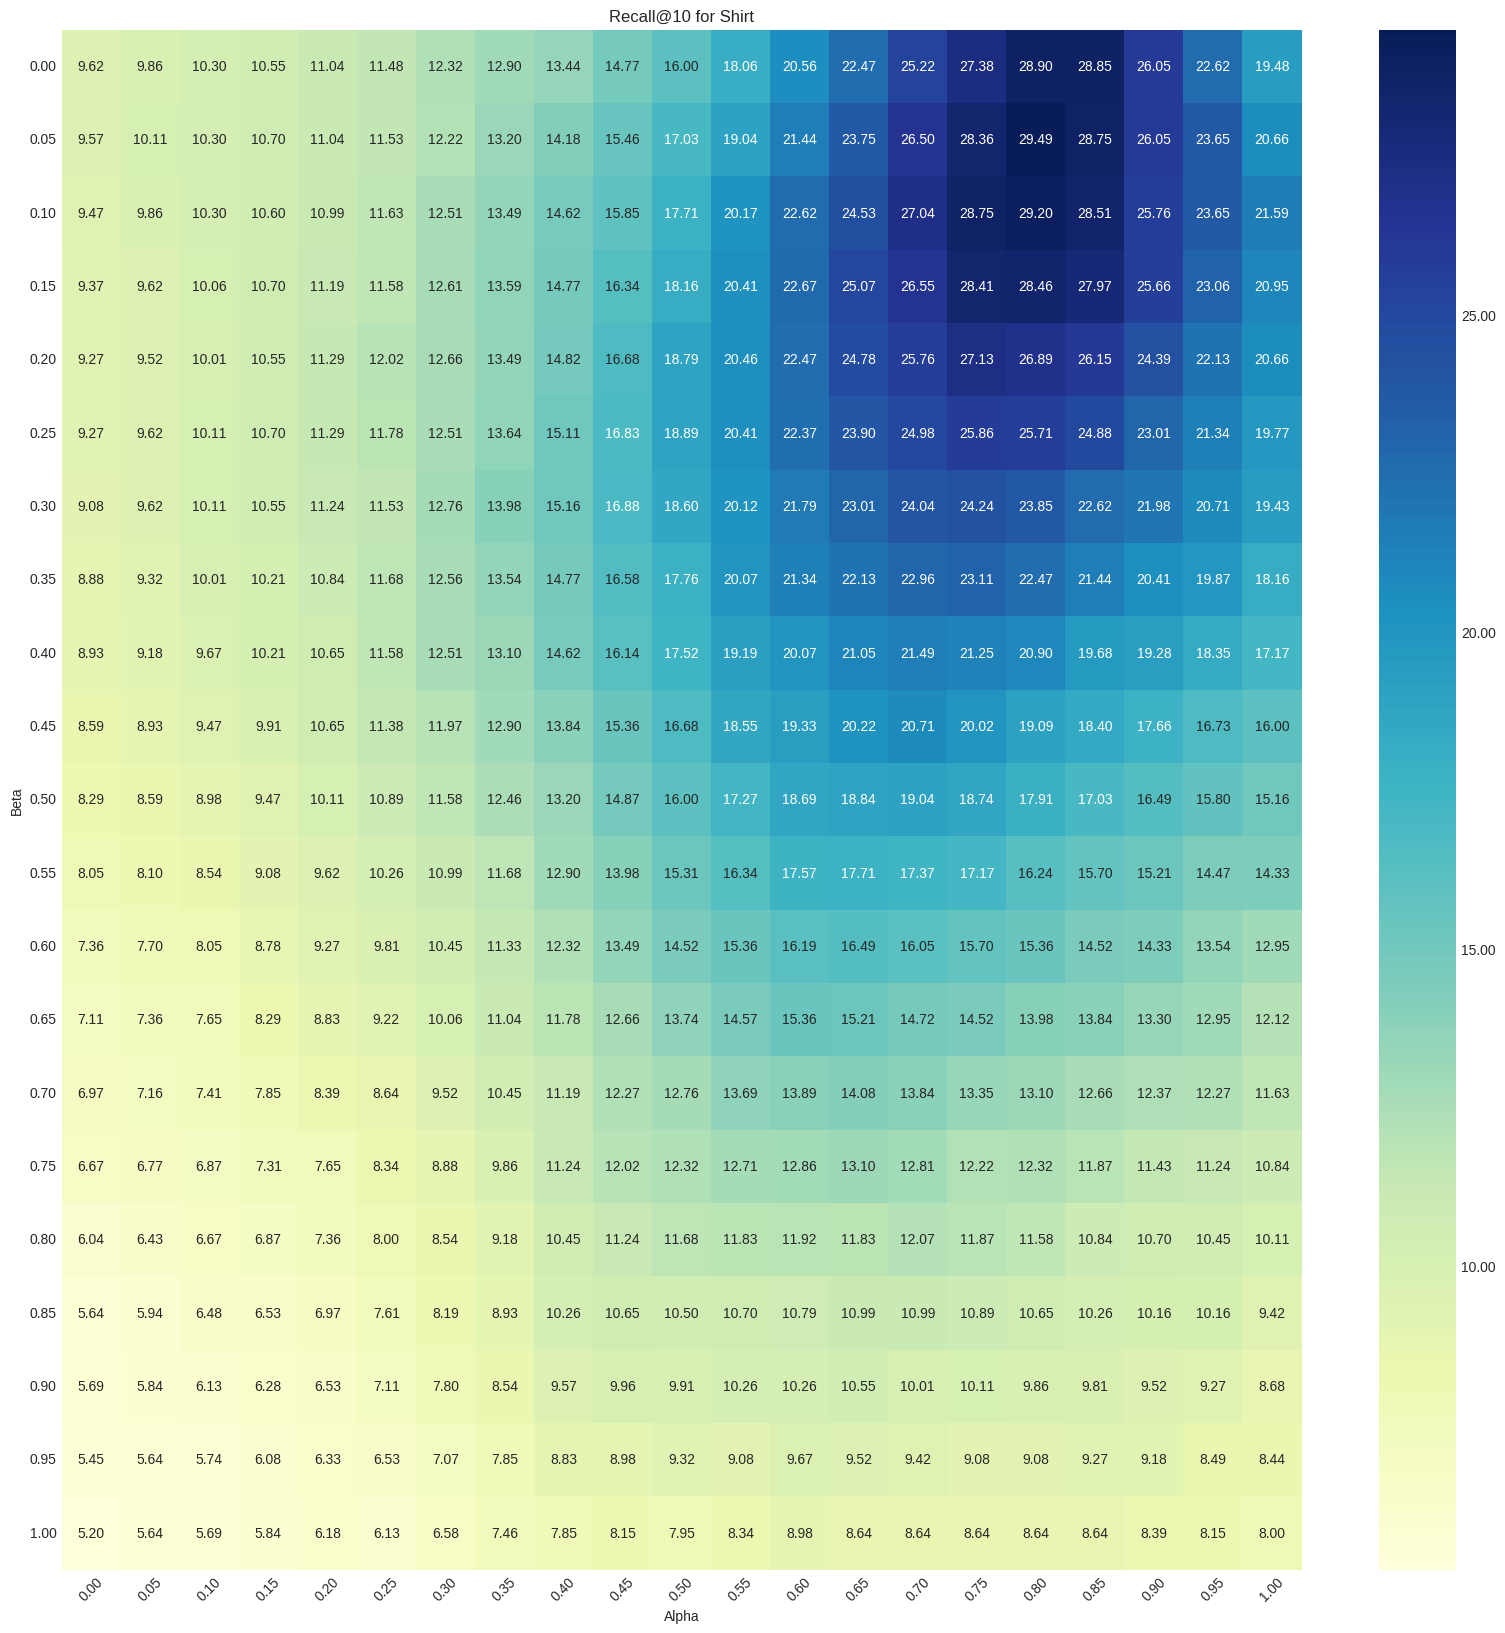

In [20]:
prepare_and_plot_recall_pivot(shirt_recall_at10, "Recall@10 for Shirt")

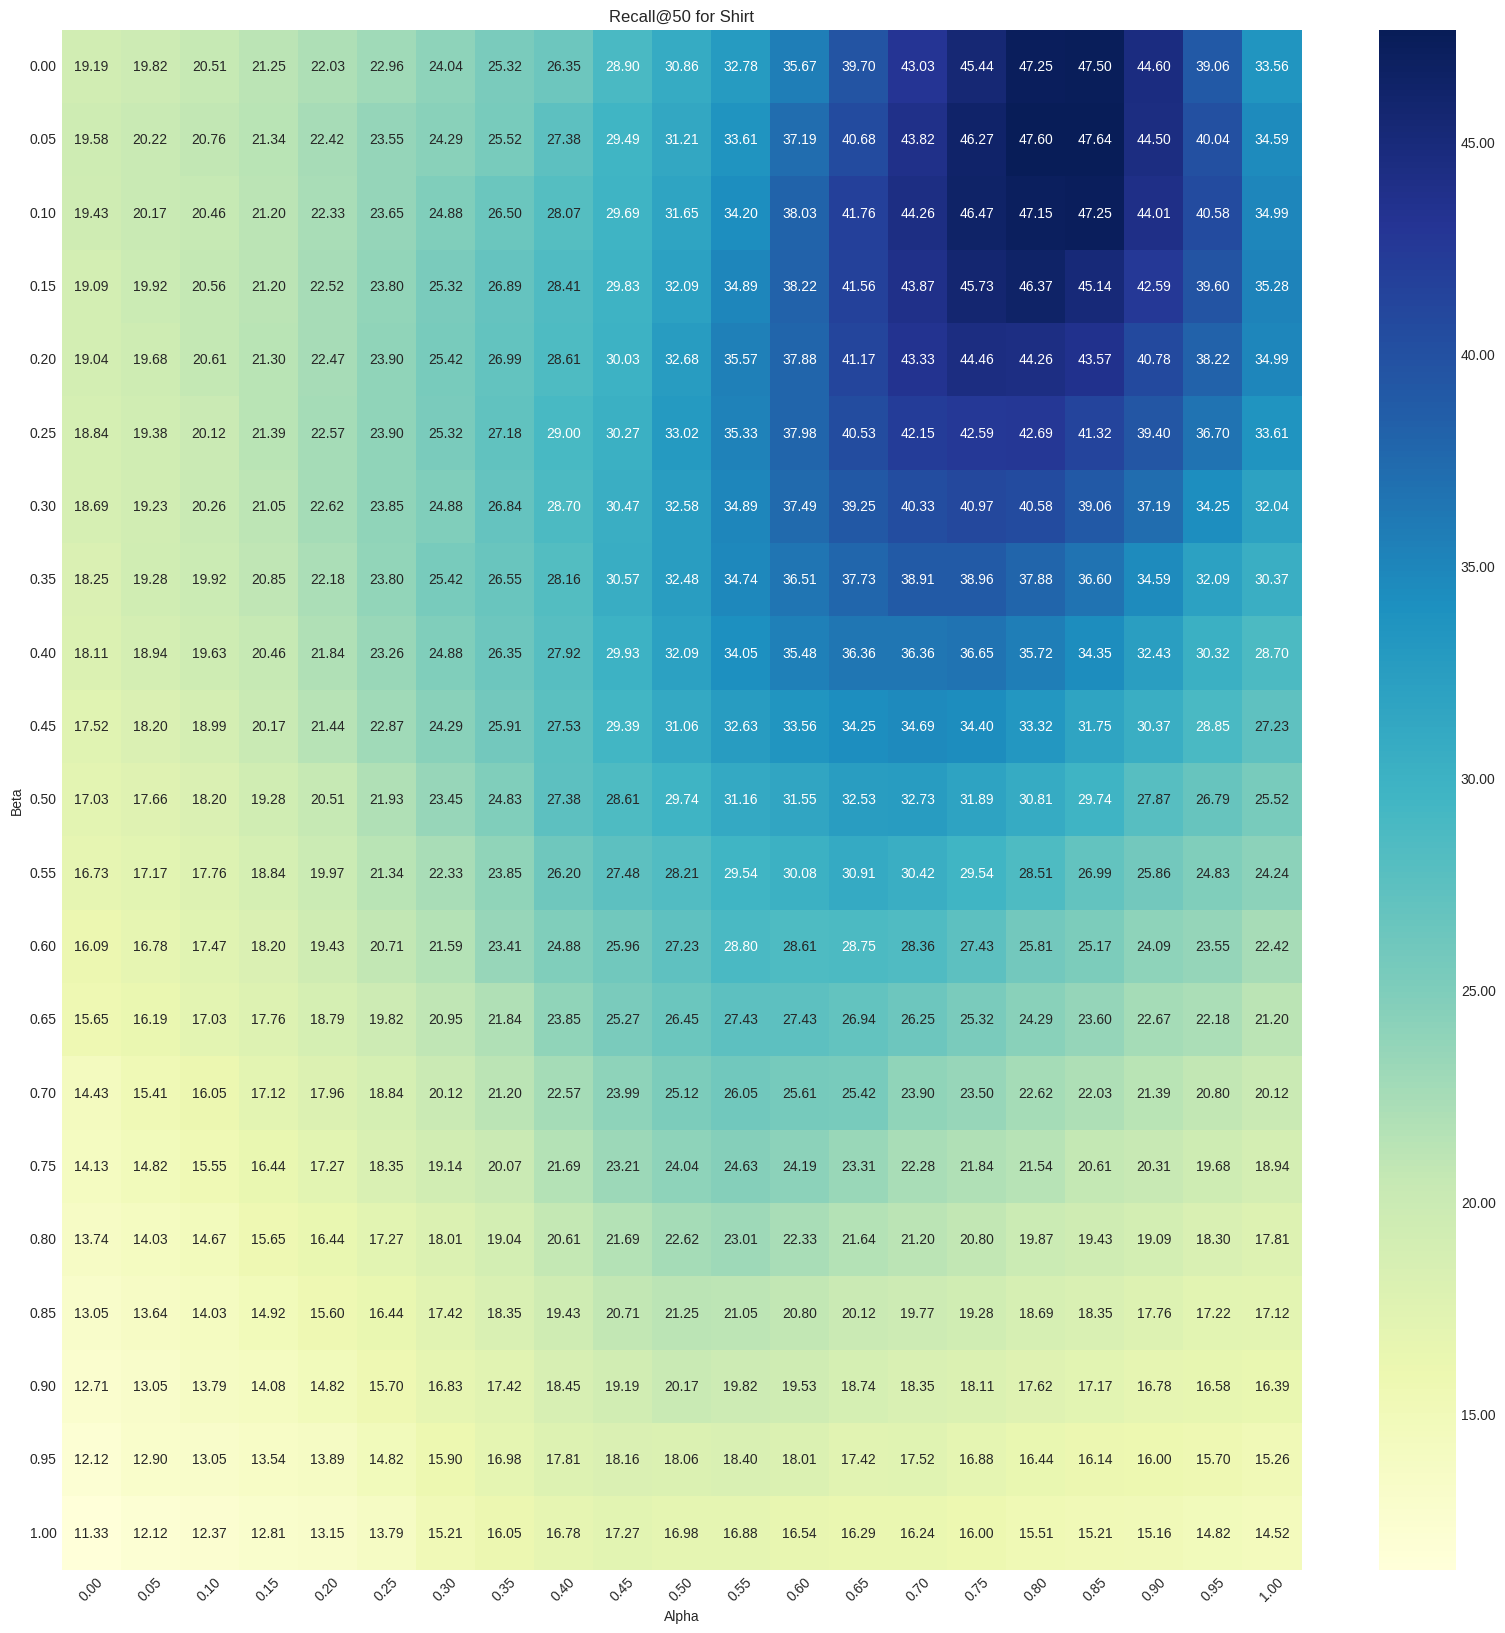

In [21]:
prepare_and_plot_recall_pivot(shirt_recall_at50, "Recall@50 for Shirt")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for Dress</div>

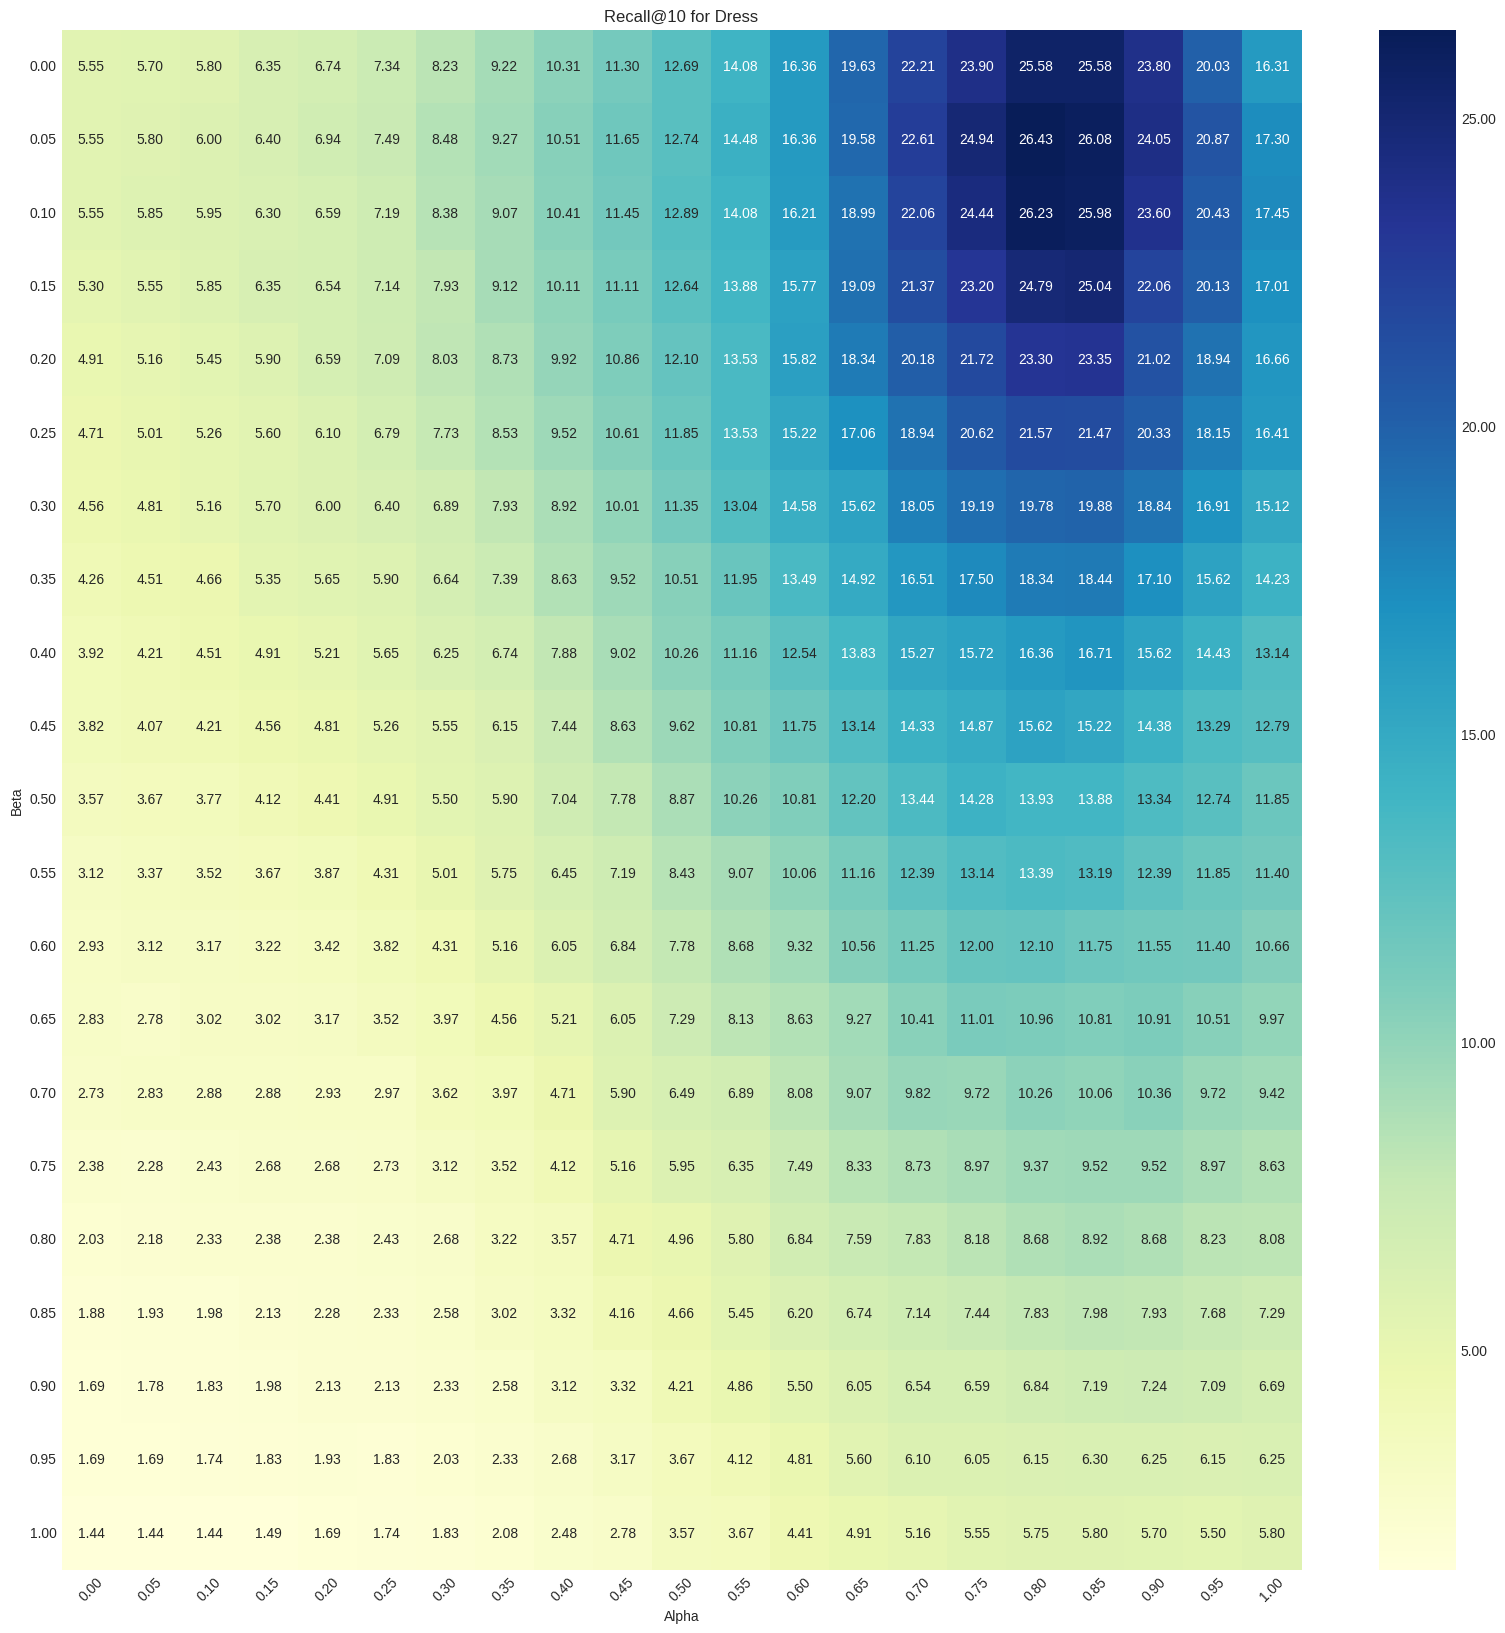

In [22]:
prepare_and_plot_recall_pivot(dress_recall_at10, "Recall@10 for Dress")

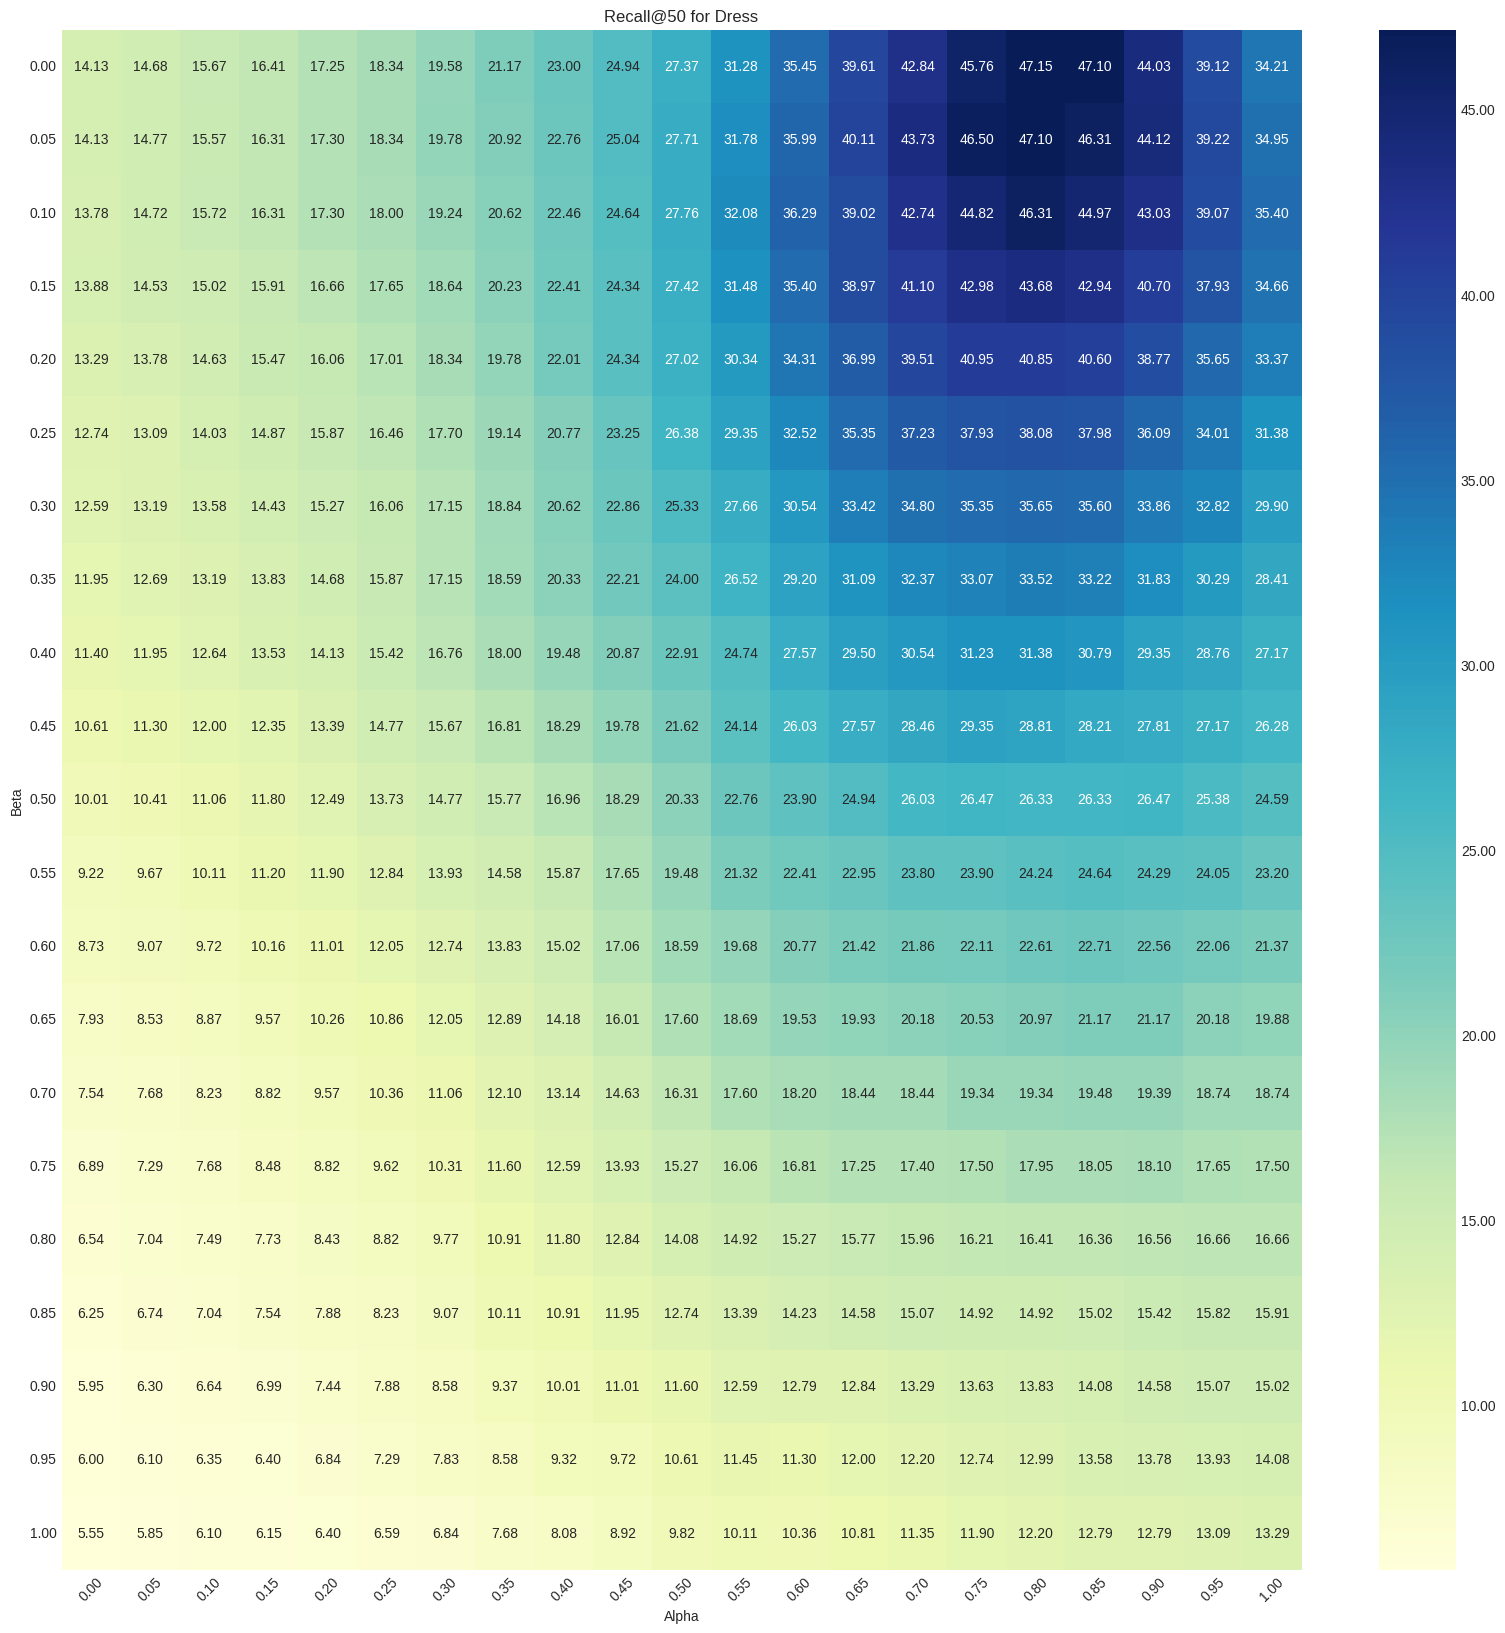

In [23]:
prepare_and_plot_recall_pivot(dress_recall_at50, "Recall@50 for Dress")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the recall at 10 and 50 for TopTee</div>

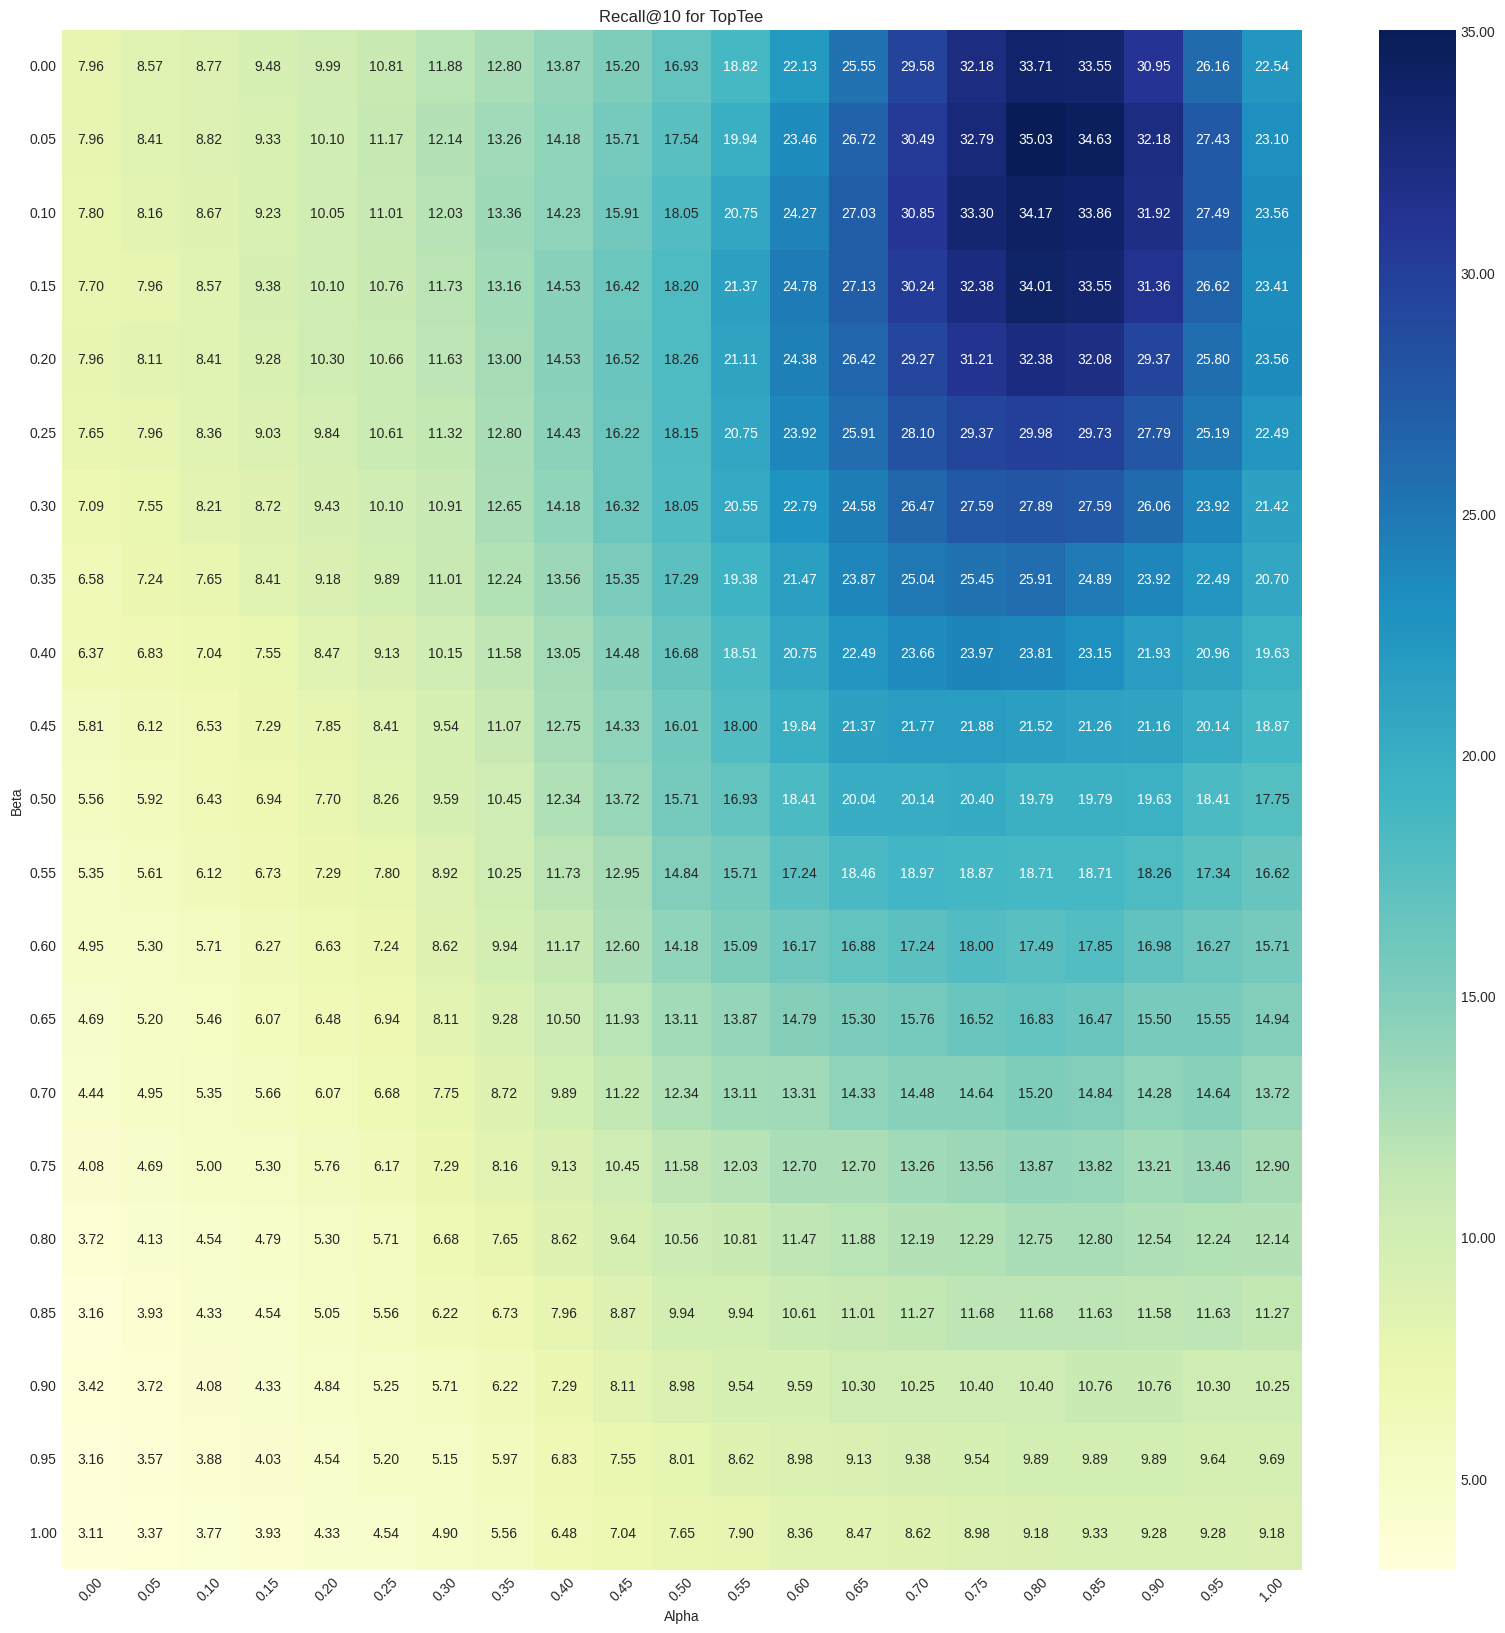

In [24]:
prepare_and_plot_recall_pivot(toptee_recall_at10, "Recall@10 for TopTee")

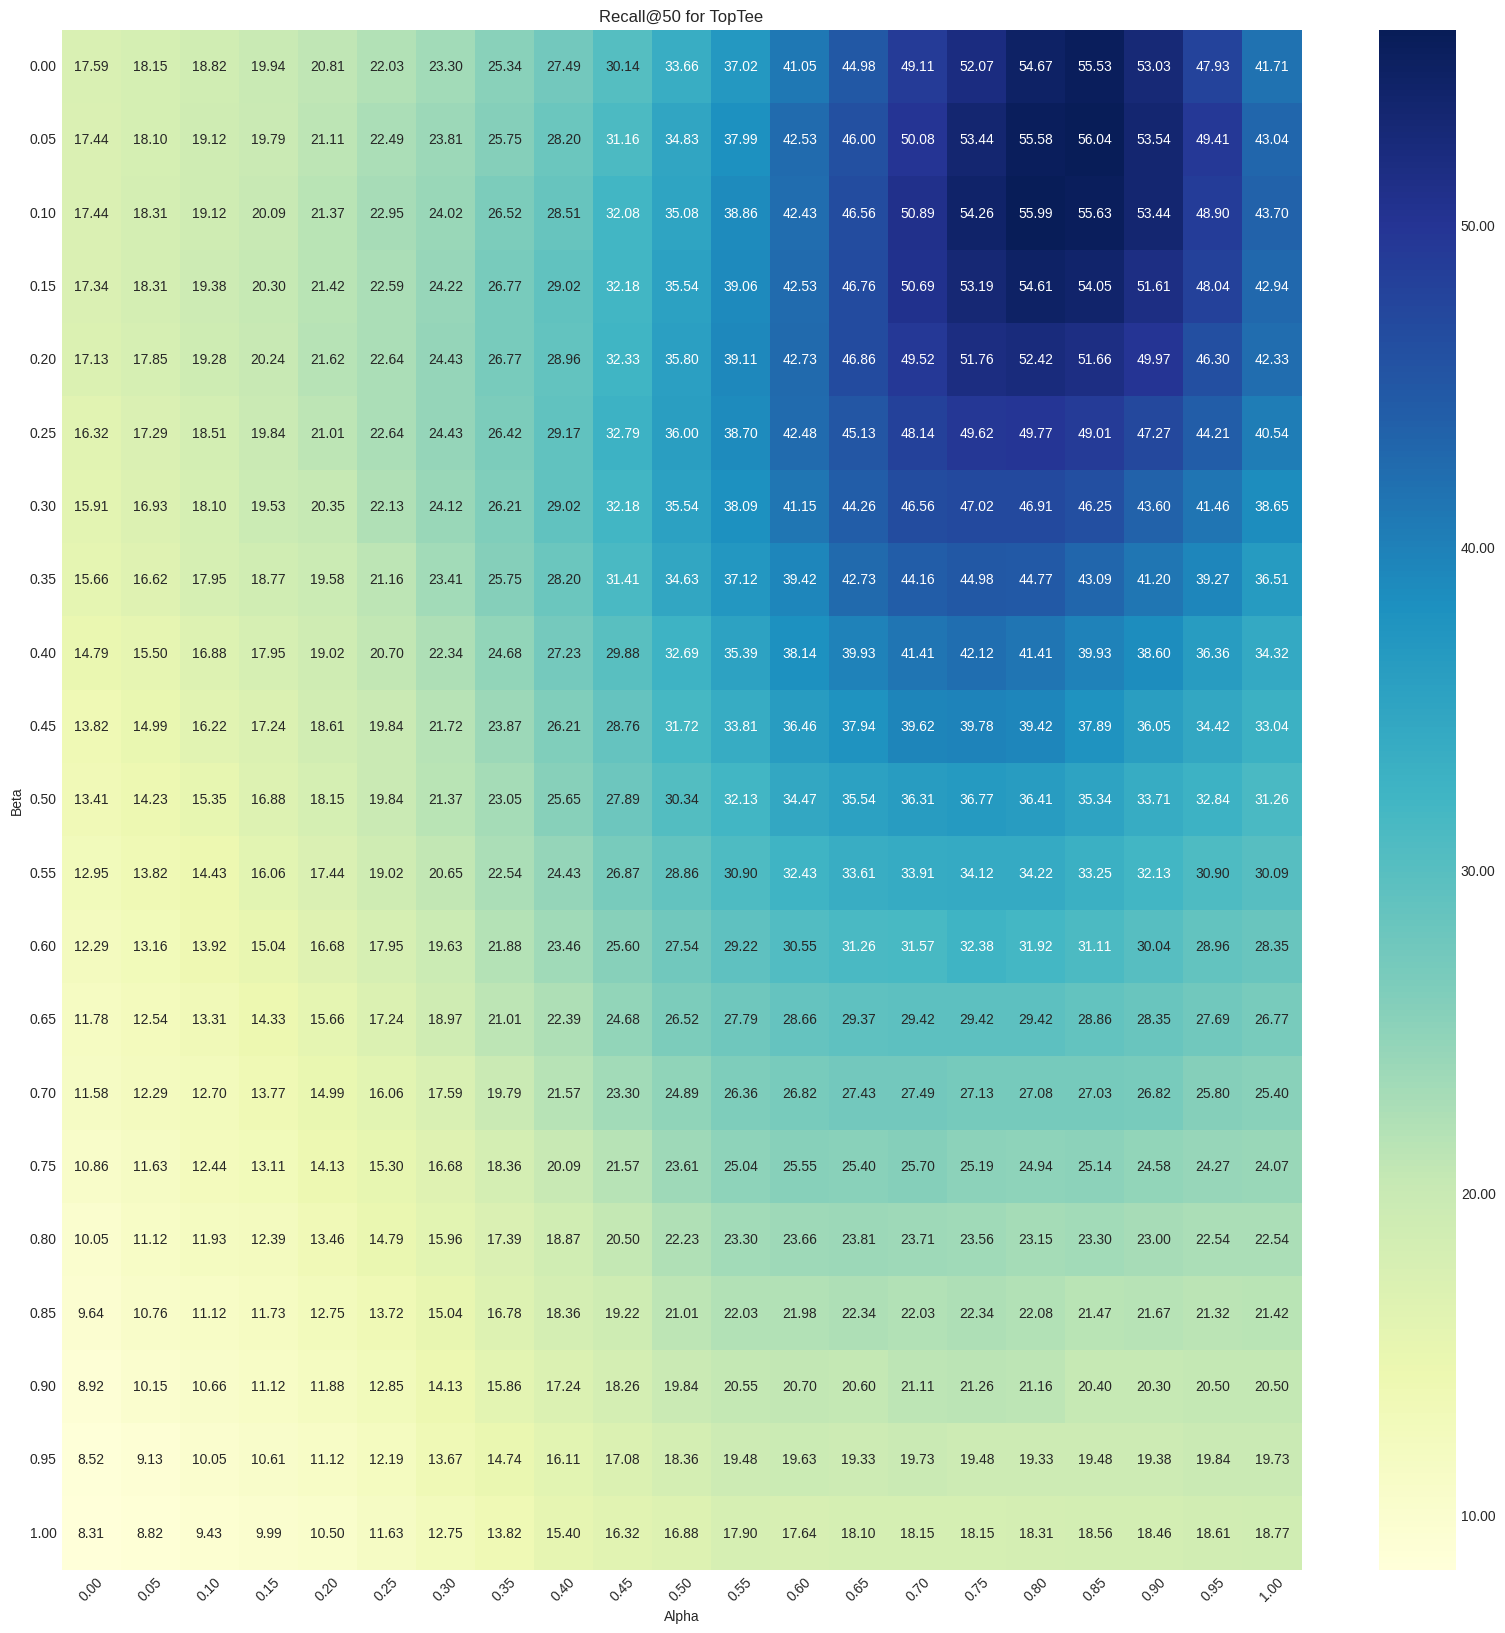

In [25]:
prepare_and_plot_recall_pivot(toptee_recall_at50, "Recall@50 for TopTee")

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the average recall at 10 and 50 for all categories</div>

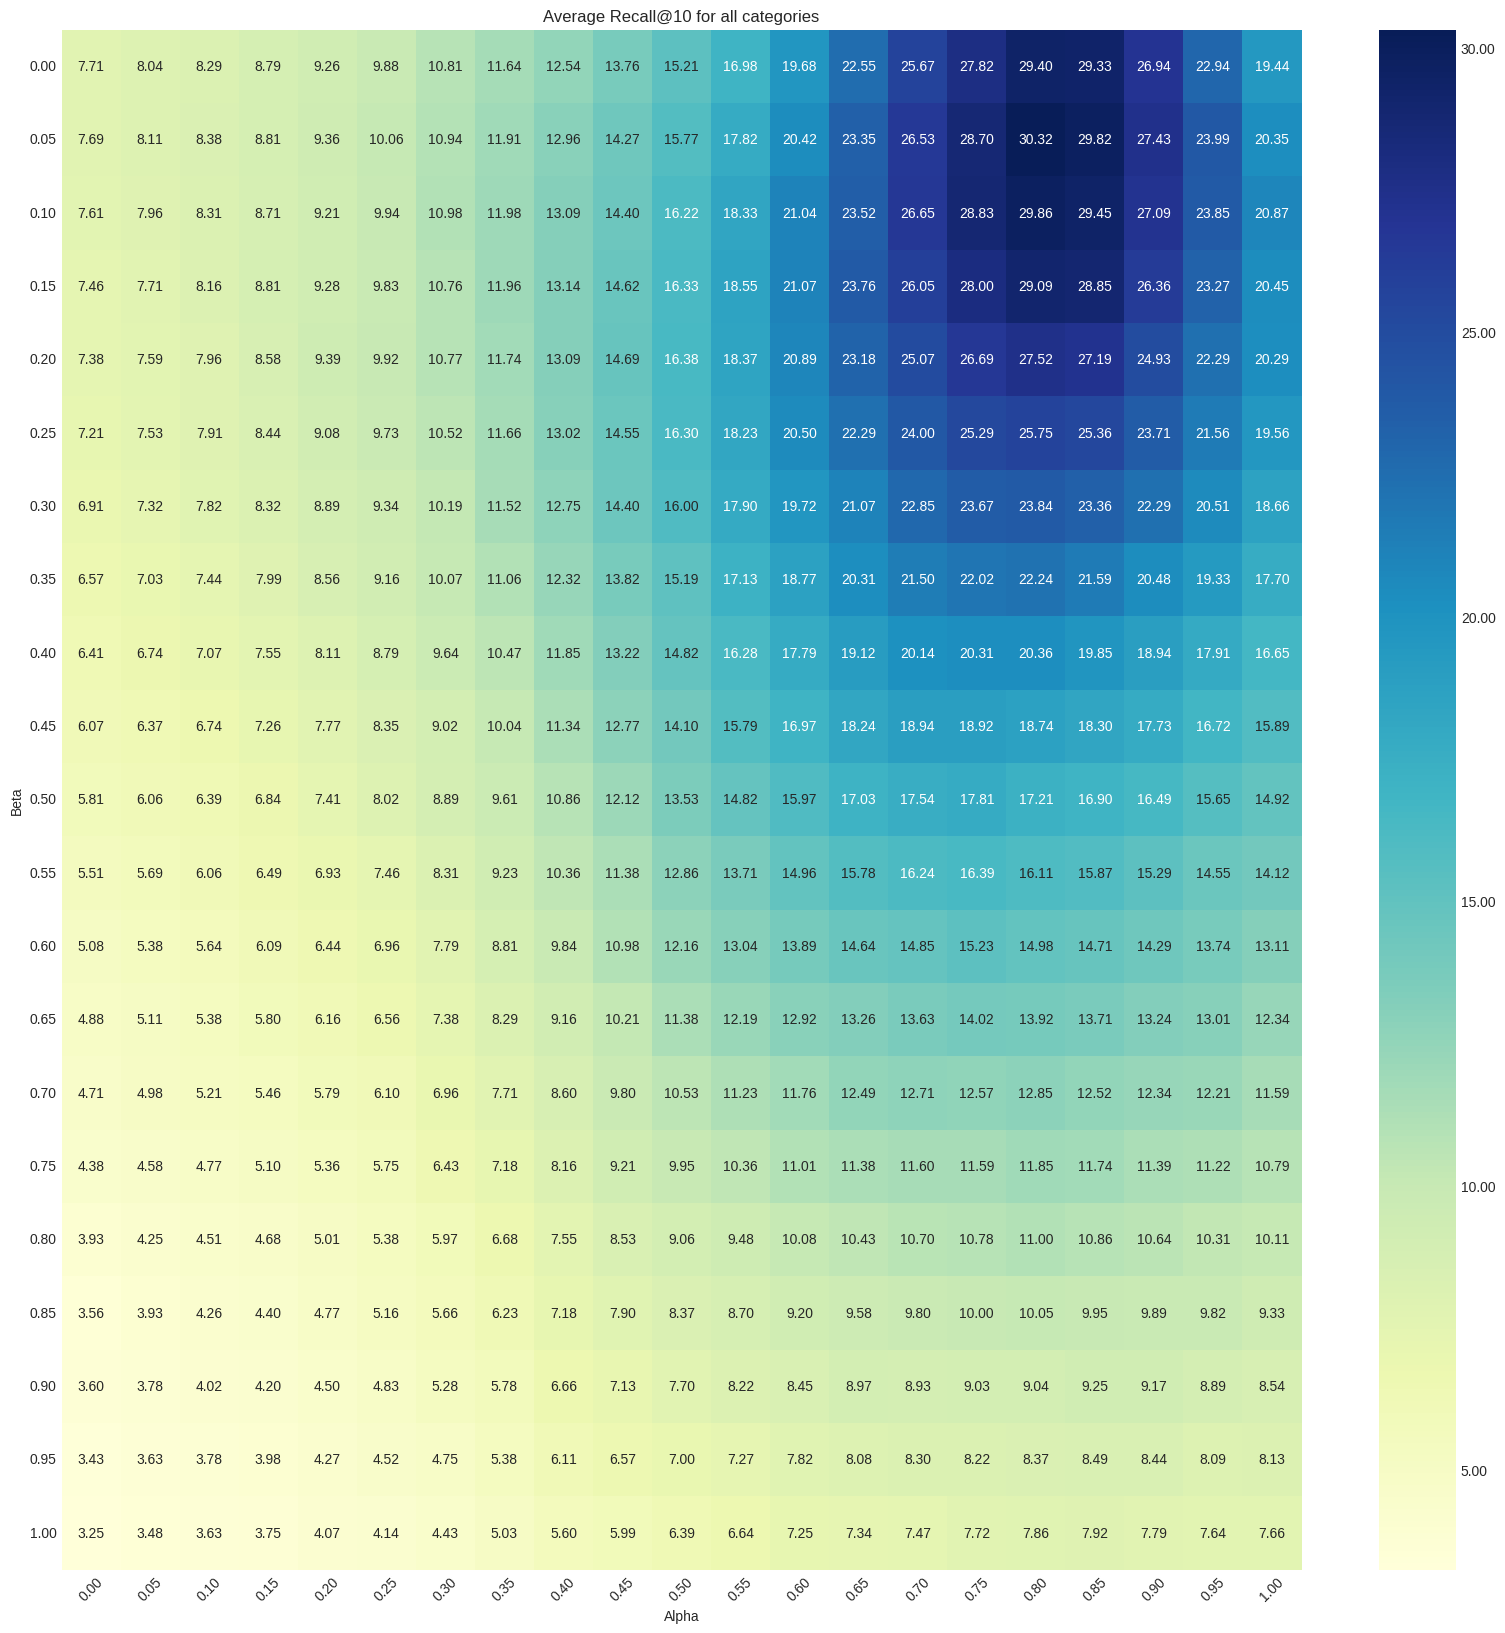

In [26]:
prepare_and_plot_recall_pivot(average_recall_at10, "Average Recall@10 for all categories")

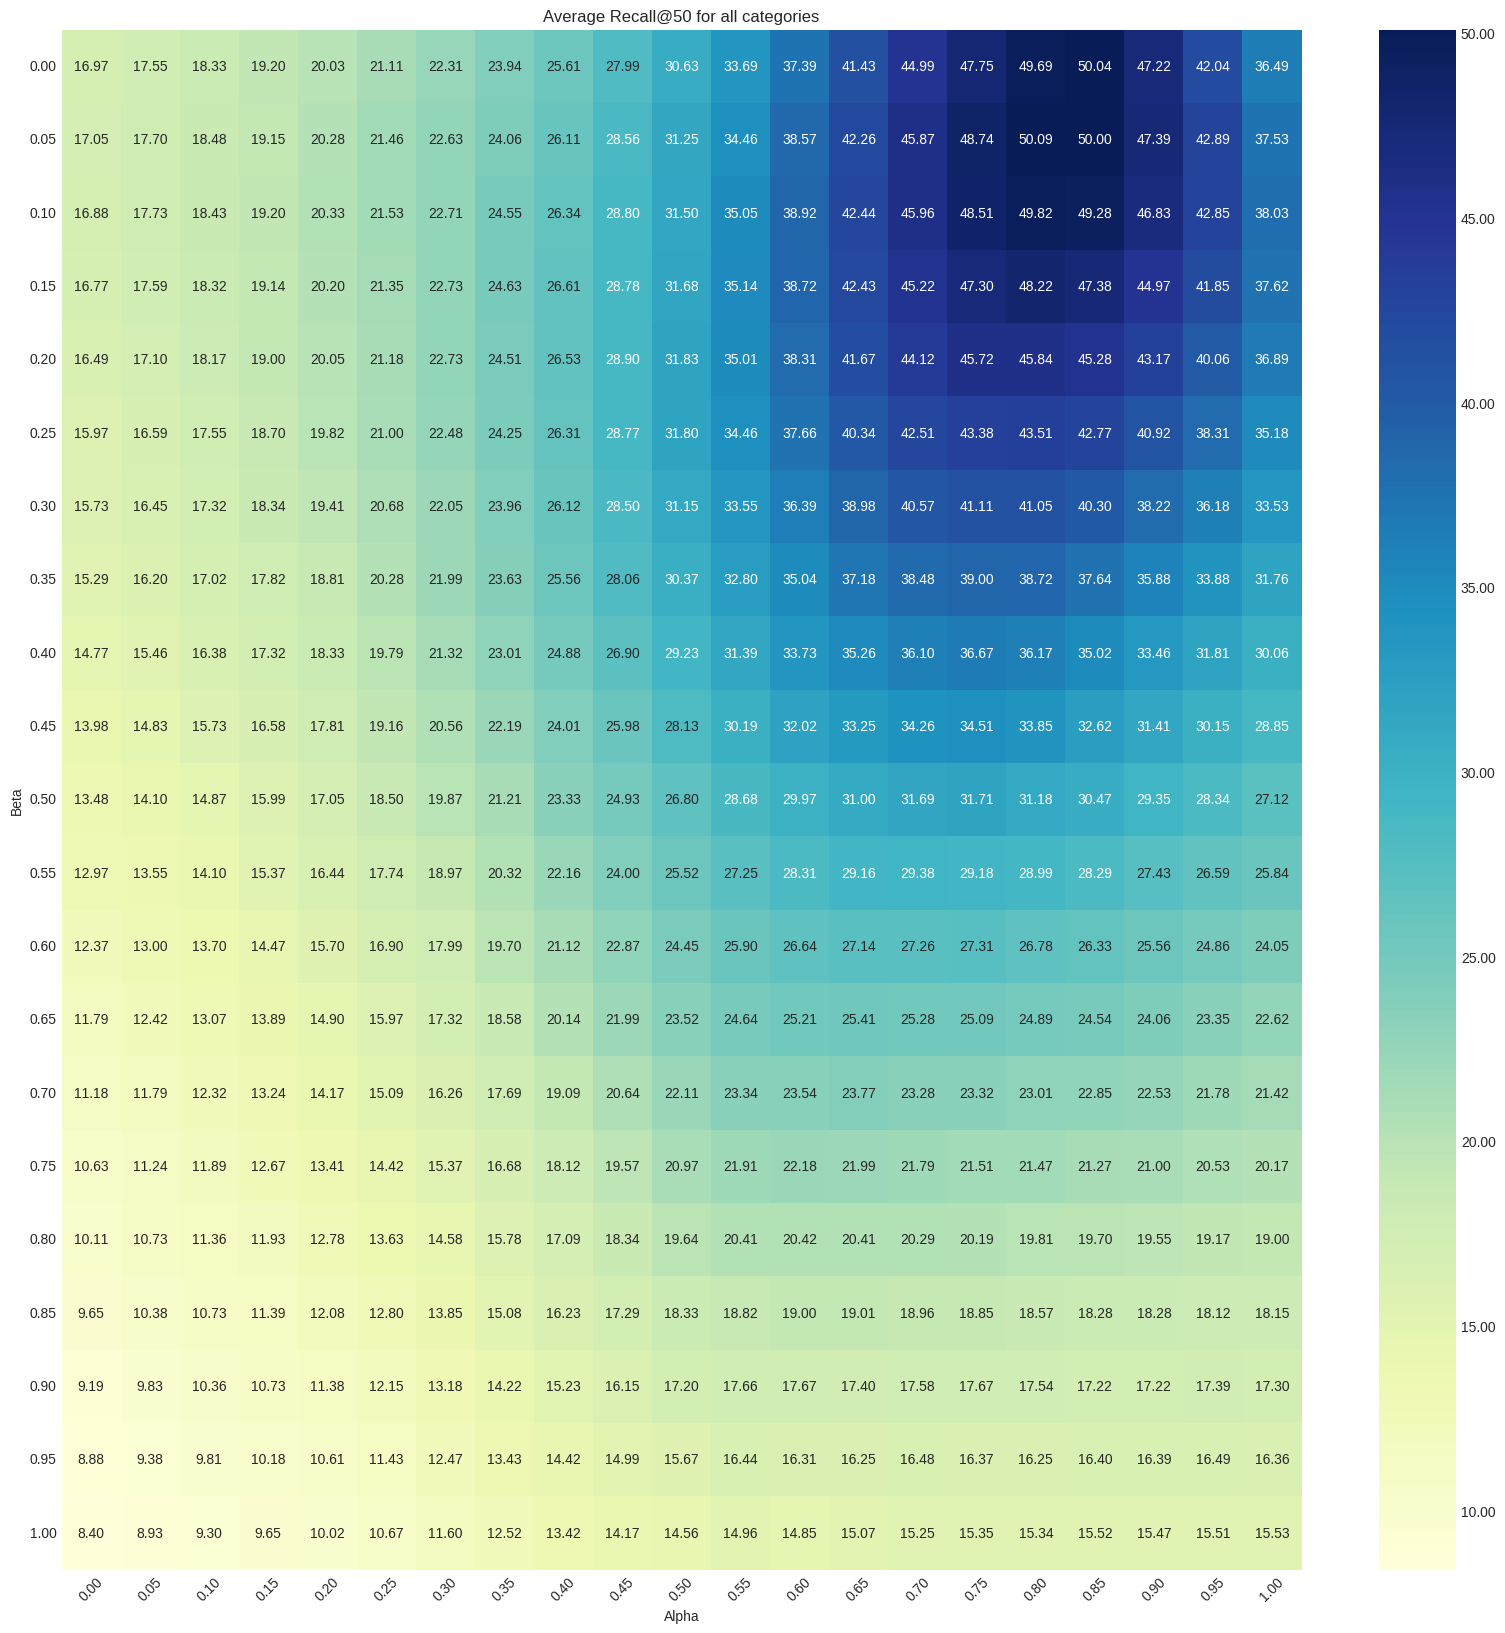

In [27]:
prepare_and_plot_recall_pivot(average_recall_at50, "Average Recall@50 for all categories")

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 5: View some sample of the result</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [28]:
sorted_indices_shirt, image_index_names_shirt, target_names_shirt = compute_results_fiq_val_clip(
    'shirt',
    get_combing_function_with_alpha(0.8),
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0.1,
    cache=cache,
)

Recall at 10: 29.1952908039093
Recall at 50: 47.15407192707062


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [29]:
sorted_indices_dress, image_index_names_dress, target_names_dress = compute_results_fiq_val_clip(
    'dress',
    get_combing_function_with_alpha(0.8),
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0.1,
    cache=cache,
)

Recall at 10: 26.22706890106201
Recall at 50: 46.306395530700684


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [30]:
sorted_indices_toptee, image_index_names_toptee, target_names_toptee = compute_results_fiq_val_clip(
    'toptee',
    get_combing_function_with_alpha(0.8),
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0.1,
    cache=cache,
)

Recall at 10: 34.16624069213867
Recall at 50: 55.99184036254883


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Prepare the ground truth data</div>

In [31]:
ground_truth_dress = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.dress.val.json')))
ground_truth_shirt = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.shirt.val.json')))
ground_truth_toptee = prepare_ground_truths(json.load(open('../../../fashionIQ_dataset/captions/cap.toptee.val.json')))

DATASET_IMAGE_DIR = '../../../fashionIQ_dataset/images/'

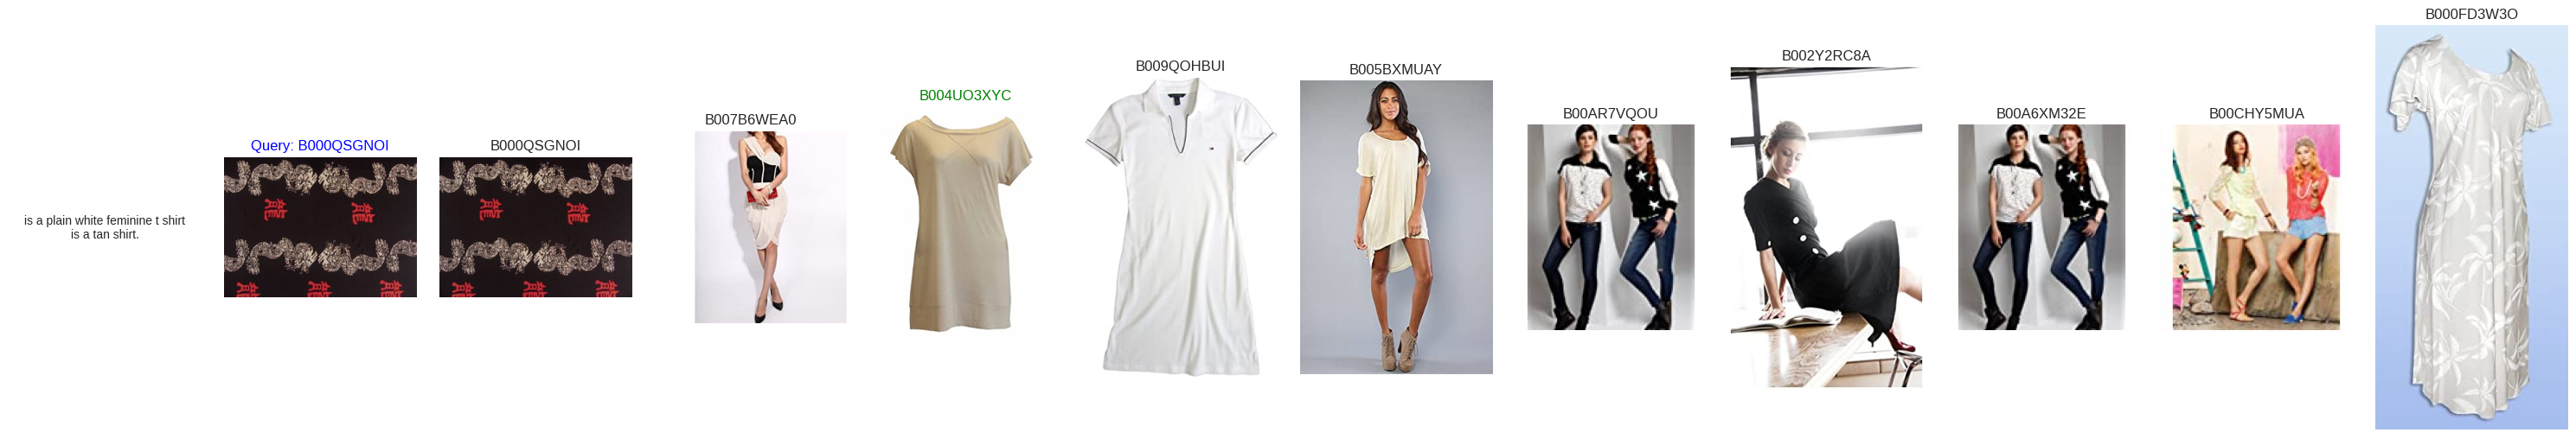

In [32]:
plot_retrieval_results_of_i(
    sorted_indices_dress, 
    image_index_names_dress, 
    target_names_dress, 
    ground_truth_dress, 
    top_k=10, 
    i=3,
    directory=DATASET_IMAGE_DIR,
)

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 6: Compare with the original without MMLM captions and identical weights element-wise sum</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Shirt category</div>

In [33]:
sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin = compute_results_fiq_val_clip(
    'shirt',
    combining_function_original,
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 15.996074676513672
Recall at 50: 30.86359202861786


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the Dress category</div>

In [34]:
sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin = compute_results_fiq_val_clip(
    'dress',
    combining_function_original,
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 12.692117691040039
Recall at 50: 27.367377281188965


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compute the results for the TopTee category</div>

In [35]:
sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin = compute_results_fiq_val_clip(
    'toptee',
    combining_function_original,
    clip_text_encoder,
    clip_img_encoder,
    clip_tokenizer,
    text_captions,
    preprocess,
    beta=0,
    cache=cache,
)

Recall at 10: 16.9301375746727
Recall at 50: 33.656299114227295


## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Shirt category</div>

In [36]:
become_better = found_better_than_original(
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    top_k=10
)

len(become_better), become_better[:10]

(338, [0, 1, 6, 12, 13, 16, 19, 20, 21, 32])

In [37]:
become_worse = found_better_than_original(
    sorted_indices_shirt, image_index_names_shirt, target_names_shirt,
    sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(65, [35, 66, 138, 150, 175, 222, 258, 263, 276, 289])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the Dress category</div>

In [38]:
become_better = found_better_than_original(
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    top_k=10
)

len(become_better), become_better[:10]

(357, [3, 12, 16, 19, 35, 40, 45, 51, 52, 55])

In [39]:
become_worse = found_better_than_original(
    sorted_indices_dress, image_index_names_dress, target_names_dress,
    sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(72, [17, 23, 62, 73, 114, 125, 129, 134, 169, 212])

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Compare the results for the TopTee category</div>

In [40]:
become_better = found_better_than_original(
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    top_k=10
)

len(become_better), become_better[:10]

(415, [4, 6, 7, 9, 10, 15, 16, 18, 21, 22])

In [41]:
become_worse = found_better_than_original(
    sorted_indices_toptee, image_index_names_toptee, target_names_toptee,
    sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin,
    top_k=10
)

len(become_worse), become_worse[:10]

(54, [12, 44, 142, 216, 292, 302, 369, 389, 403, 520])

# <div style="font-family: 'Garamond', serif; font-size: 22px; color: #ffffff; background-color: #34568B; text-align: center; padding: 15px; border-radius: 10px; border: 2px solid #FF6F61; box-shadow: 0 6px 12px rgba(0, 0, 0, 0.3); margin-bottom: 20px;">Step 7: Visualize the comparison</div>

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Shirt category</div>

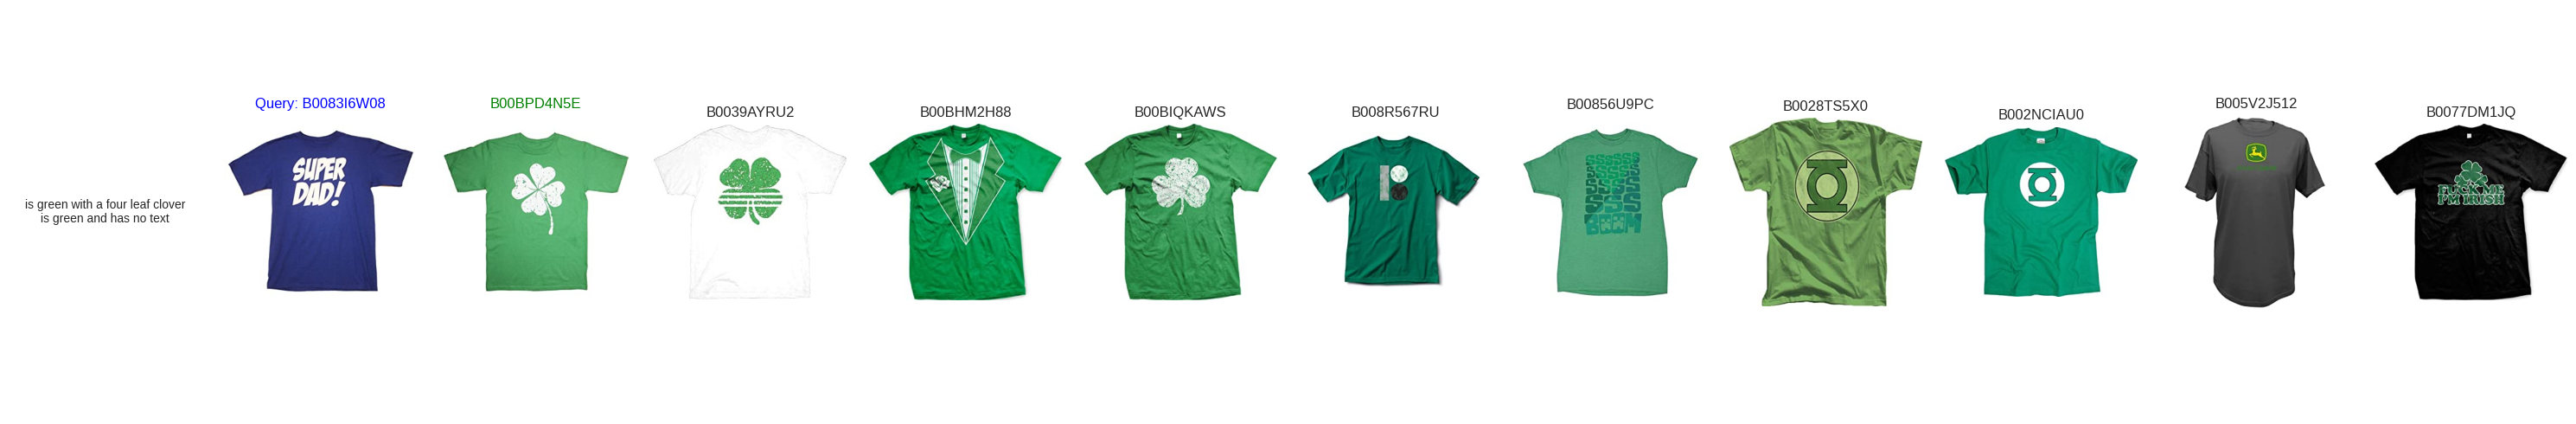

In [42]:
plot_retrieval_results_of_i(sorted_indices_shirt, image_index_names_shirt, target_names_shirt, ground_truth_shirt, top_k=10, i=1, directory=DATASET_IMAGE_DIR)

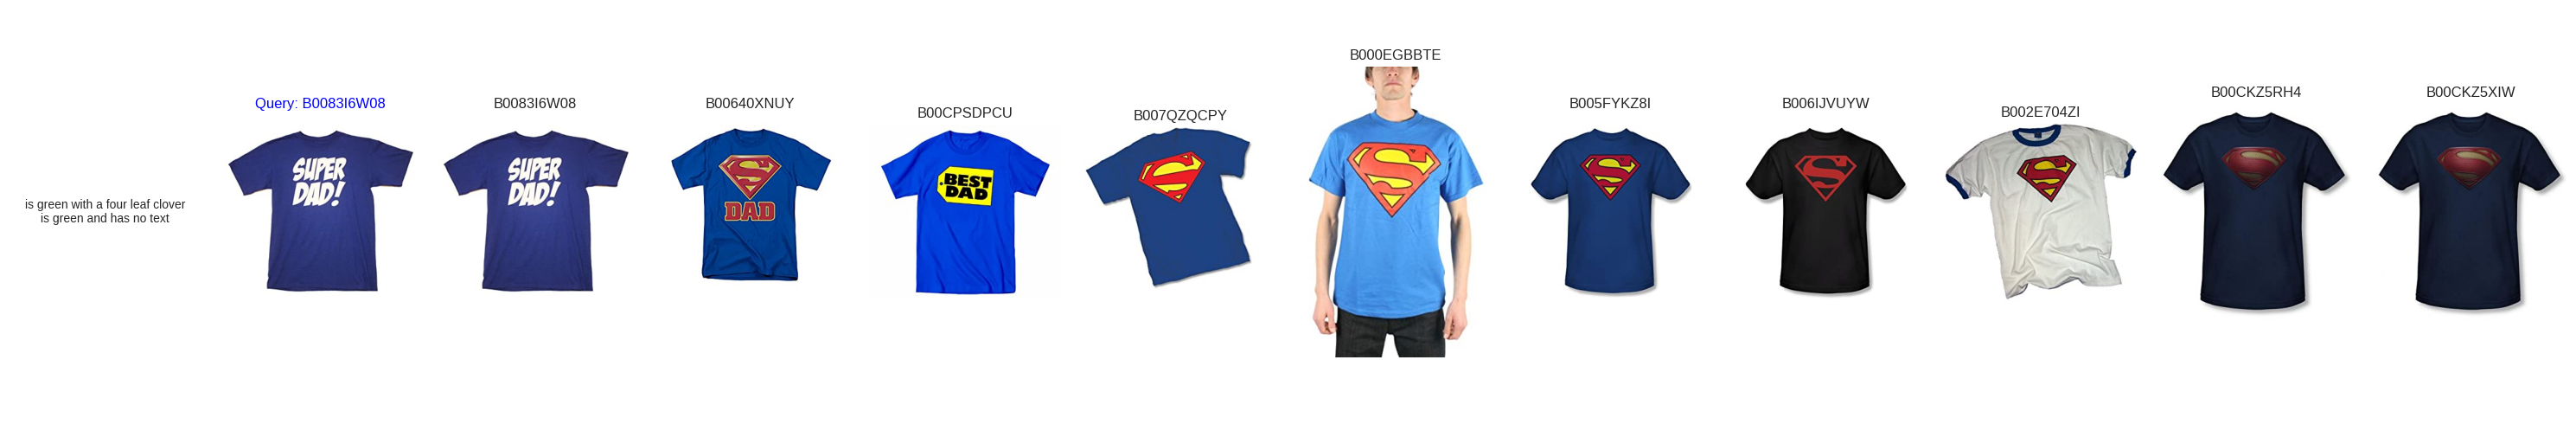

In [43]:
plot_retrieval_results_of_i(sorted_indices_shirt_origin, image_index_names_shirt_origin, target_names_shirt_origin, ground_truth_shirt, top_k=10, i=1, directory=DATASET_IMAGE_DIR)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the Dress category</div>

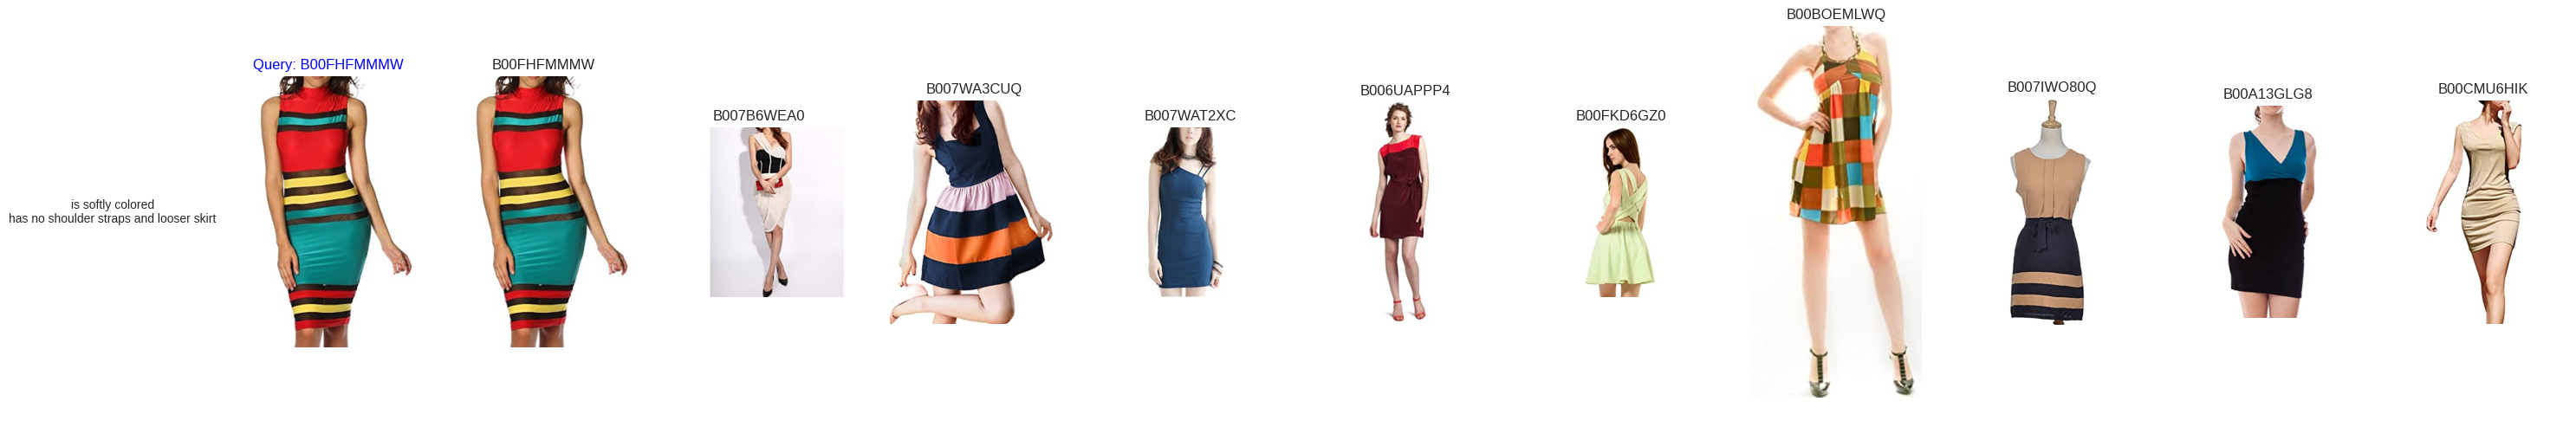

In [44]:
plot_retrieval_results_of_i(sorted_indices_dress, image_index_names_dress, target_names_dress, ground_truth_dress, top_k=10, i=11, directory=DATASET_IMAGE_DIR)

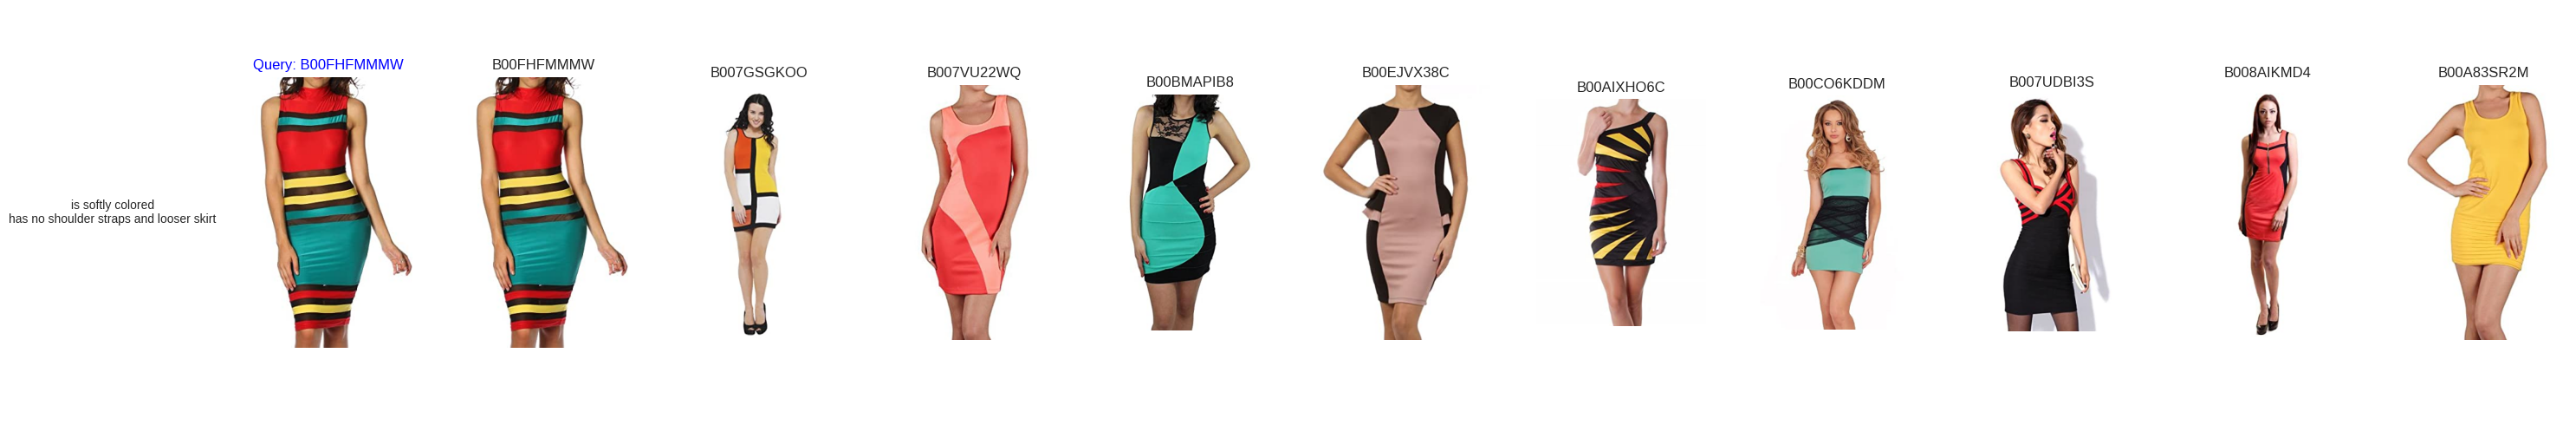

In [45]:
plot_retrieval_results_of_i(sorted_indices_dress_origin, image_index_names_dress_origin, target_names_dress_origin, ground_truth_dress, top_k=10, i=11, directory=DATASET_IMAGE_DIR)

## <div style="font-family: 'Lucida Sans Unicode', sans-serif; font-size: 18px; color: #4A235A; background-color: #D7BDE2; text-align: left; padding: 10px; border-left: 5px solid #7D3C98; box-shadow: 0 4px 6px rgba(0, 0, 0, 0.2); margin-bottom: 10px;">Plot the results for the TopTee category</div>

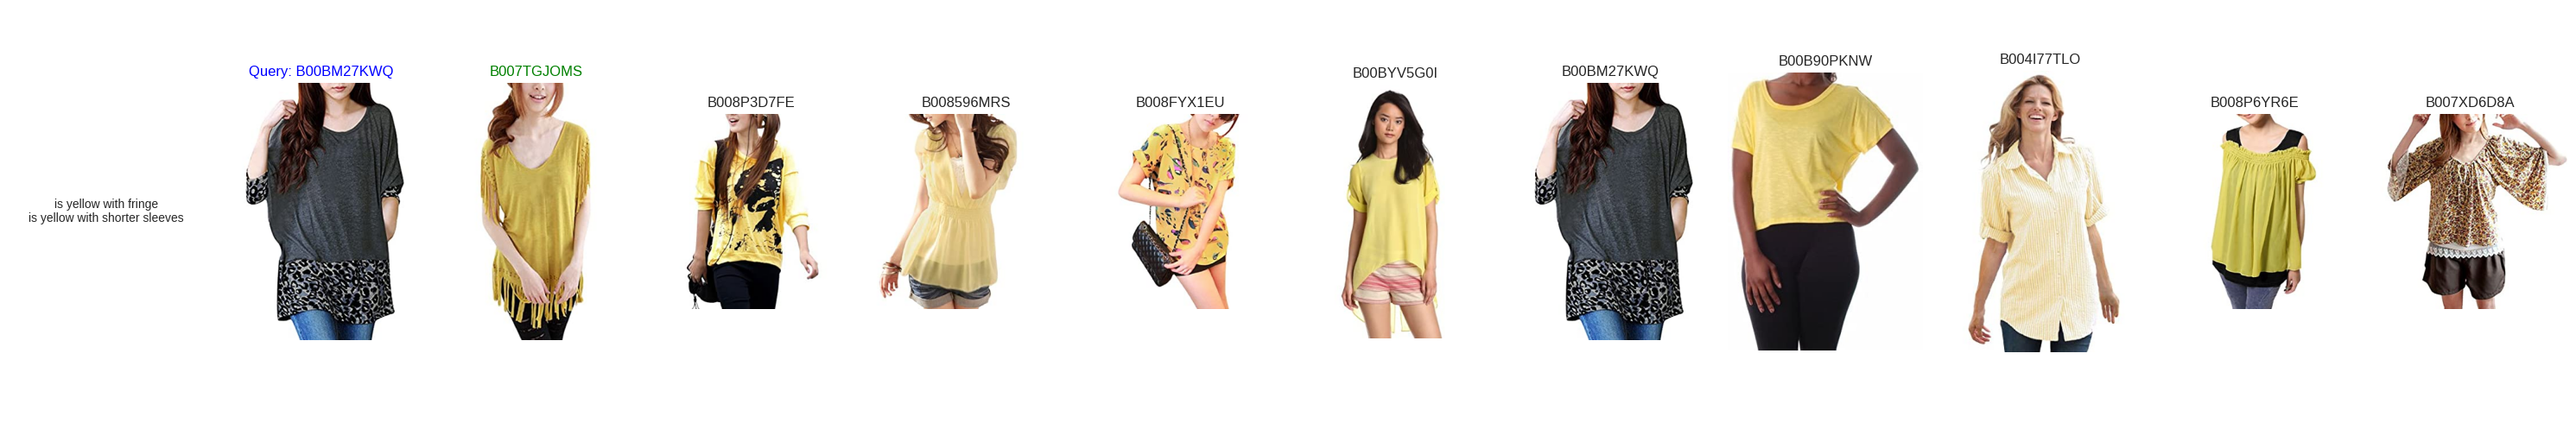

In [46]:
plot_retrieval_results_of_i(sorted_indices_toptee, image_index_names_toptee, target_names_toptee, ground_truth_toptee, top_k=10, i=2, directory=DATASET_IMAGE_DIR)

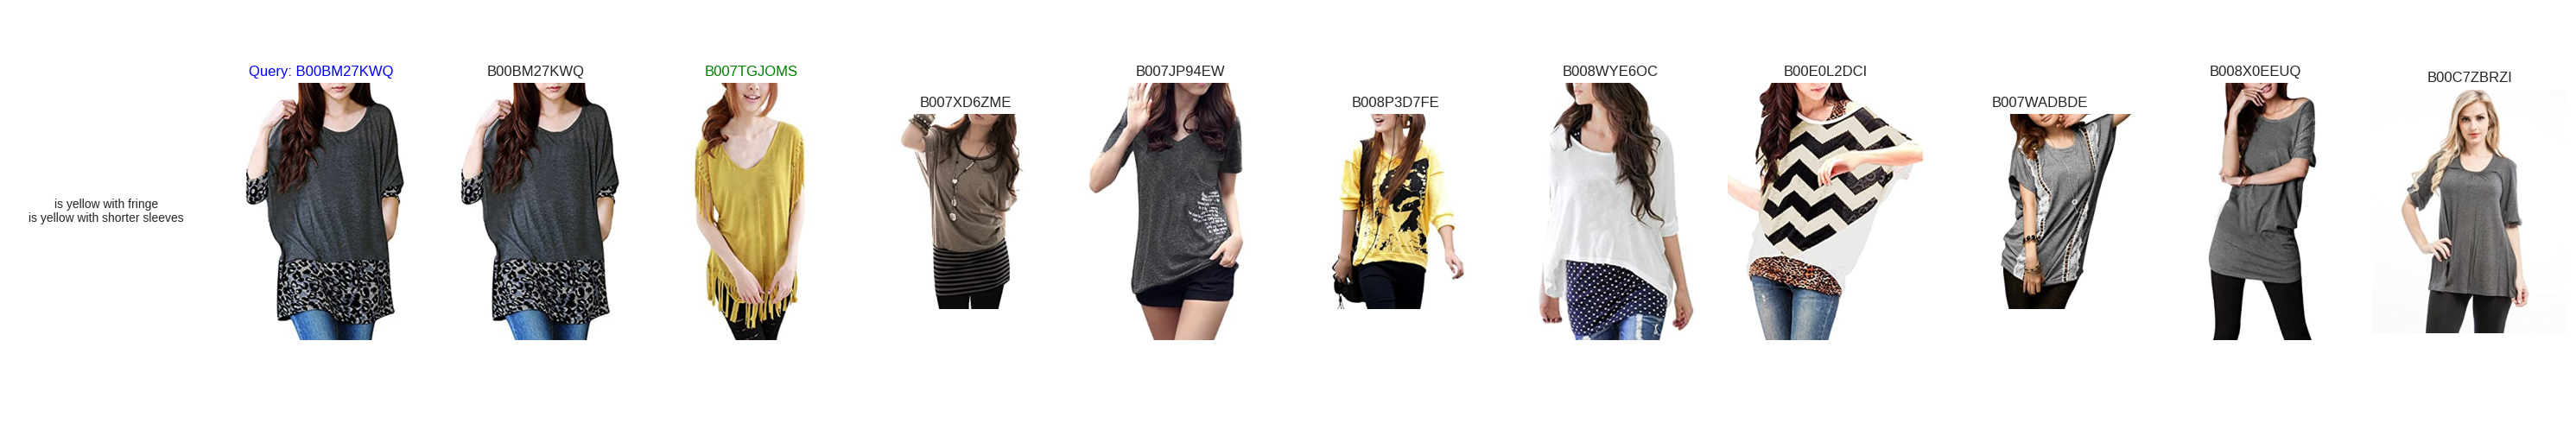

In [47]:
plot_retrieval_results_of_i(sorted_indices_toptee_origin, image_index_names_toptee_origin, target_names_toptee_origin, ground_truth_toptee, top_k=10, i=2, directory=DATASET_IMAGE_DIR)